<a href="https://colab.research.google.com/github/xyzsh7/MAAs1/blob/sherryxz/Airline_Customer_Satisfaction_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset read in & preprocess

##package import

In [ ]:
!pip install graphviz
!pip install yellowbrick
!pip install --quiet optuna
!pip install catboost
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from imblearn.over_sampling import SMOTE
from pickle import TRUE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
import optuna
from yellowbrick.regressor import prediction_error
import tensorflow as tf
from scipy.cluster.hierarchy import linkage, dendrogram
sns.set()

##Read in dataset

In [ ]:
#set path in google colab environment
#the following code connect to own google drive and connect the csv file
drive.mount('/content/drive')
path_test='/content/drive/MyDrive/test.csv'
path_train='/content/drive/MyDrive/train.csv'
train_df=pd.read_csv(path_train)
test_df=pd.read_csv(path_test)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_df

Unnamed: 0      id  Gender      Customer Type  Age   Type of Travel  \
0                0   70172    Male     Loyal Customer   13  Personal Travel   
1                1    5047    Male  disloyal Customer   25  Business travel   
2                2  110028  Female     Loyal Customer   26  Business travel   
3                3   24026  Female     Loyal Customer   25  Business travel   
4                4  119299    Male     Loyal Customer   61  Business travel   
...            ...     ...     ...                ...  ...              ...   
103899      103899   94171  Female  disloyal Customer   23  Business travel   
103900      103900   73097    Male     Loyal Customer   49  Business travel   
103901      103901   68825    Male  disloyal Customer   30  Business travel   
103902      103902   54173  Female  disloyal Customer   22  Business travel   
103903      103903   62567    Male     Loyal Customer   27  Business travel   

           Class  Flight Distance  Inflight wifi service  \
0       Eco Plus              460                      3   
1       Business              235                      3   
2       Business             1142                      2   
3       Business              562                      2   
4       Business              214                      3   
...          ...              ...                    ...   
103899       Eco              192                      2   
103900  Business             2347                      4   
103901  Business             1995                      1   
103902       Eco             1000                      1   
103903  Business             1723                      1   

        Departure/Arrival time convenient  ...  Inflight entertainment  \
0                                       4  ...                       5   
1                                       2  ...                       1   
2                                       2  ...                       5   
3                                       5  ...                       2   
4                                       3  ...                       3   
...                                   ...  ...                     ...   
103899                                  1  ...                       2   
103900                                  4  ...                       5   
103901                                  1  ...                       4   
103902                                  1  ...                       1   
103903                                  3  ...                       1   

        On-board service  Leg room service  Baggage handling  Checkin service  \
0                      4                 3                 4                4   
1                      1                 5                 3                1   
2                      4                 3                 4                4   
3                      2                 5                 3                1   
4                      3                 4                 4                3   
...                  ...               ...               ...              ...   
103899                 3                 1                 4                2   
103900                 5                 5                 5                5   
103901                 3                 2                 4                5   
103902                 4                 5                 1                5   
103903                 1                 1                 4                4   

        Inflight service  Cleanliness  Departure Delay in Minutes  \
0                      5            5                          25   
1                      4            1                           1   
2                      4            5                           0   
3                      4            2                          11   
4                      3            3                           0   
...                  ...          ...                         

##Dataset cleaning, spliting & preprocess

In [ ]:
#set index and remove the 'unnamed column'
train = train_df.drop('Unnamed: 0',axis=1)
train = train.set_index('id')
test = test_df.drop('Unnamed: 0',axis=1)
test = test.set_index('id')

In [ ]:
#replace categorical variables with dummies
train_d = pd.get_dummies(train,
                     columns = ['Gender', 'Customer Type','Type of Travel','Class','satisfaction'],drop_first= True)
test_d = pd.get_dummies(test,
                     columns = ['Gender', 'Customer Type','Type of Travel','Class','satisfaction'],drop_first= True)

#fill nan with median in the train data
medianTrain = train_d['Arrival Delay in Minutes'].median() 
train_d['Arrival Delay in Minutes'].fillna(value=medianTrain, inplace=True)

medianTest = test_d['Arrival Delay in Minutes'].median() 
test_d['Arrival Delay in Minutes'].fillna(value=medianTest, inplace=True)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103904 entries, 70172 to 62567
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103904 non-null  object 
 1   Customer Type                      103904 non-null  object 
 2   Age                                103904 non-null  int64  
 3   Type of Travel                     103904 non-null  object 
 4   Class                              103904 non-null  object 
 5   Flight Distance                    103904 non-null  int64  
 6   Inflight wifi service              103904 non-null  int64  
 7   Departure/Arrival time convenient  103904 non-null  int64  
 8   Ease of Online booking             103904 non-null  int64  
 9   Gate location                      103904 non-null  int64  
 10  Food and drink                     103904 non-null  int64  
 11  Online boarding                    1

In [ ]:
test.isnull().sum() 
#train_d.isnull().sum() 

Gender                                0
Customer Type                         0
Age                                   0
Type of Travel                        0
Class                                 0
Flight Distance                       0
Inflight wifi service                 0
Departure/Arrival time convenient     0
Ease of Online booking                0
Gate location                         0
Food and drink                        0
Online boarding                       0
Seat comfort                          0
Inflight entertainment                0
On-board service                      0
Leg room service                      0
Baggage handling                      0
Checkin service                       0
Inflight service                      0
Cleanliness                           0
Departure Delay in Minutes            0
Arrival Delay in Minutes             83
satisfaction                          0
dtype: int64

In [ ]:
#separating features(x) and target(y)
X_train = train_d.iloc[:, :-1]
y_train = train_d.iloc[:, -1]

X_test = test_d.iloc[:, :-1]
y_test = test_d.iloc[:, -1]

# train/validation/test split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

In [ ]:
#apply Synthetic Minority Oversampling Technique (SMOTE)
smote = SMOTE(random_state=42)
X_train_os, y_train_os = smote.fit_resample(X_train, y_train)

#check if the imbalance have been fixed
print(y_train_os.value_counts()/y_train_os.count())

0    0.5
1    0.5
Name: satisfaction_satisfied, dtype: float64


In [ ]:
#checking correlation
train_d[train_d.columns[1:]].corr()['satisfaction_satisfied'][:-1]

Flight Distance                      0.298780
Inflight wifi service                0.284245
Departure/Arrival time convenient   -0.051601
Ease of Online booking               0.171705
Gate location                        0.000682
Food and drink                       0.209936
Online boarding                      0.503557
Seat comfort                         0.349459
Inflight entertainment               0.398059
On-board service                     0.322383
Leg room service                     0.313131
Baggage handling                     0.247749
Checkin service                      0.236174
Inflight service                     0.244741
Cleanliness                          0.305198
Departure Delay in Minutes          -0.050494
Arrival Delay in Minutes            -0.057435
Gender_Male                          0.012211
Customer Type_disloyal Customer     -0.187638
Type of Travel_Personal Travel      -0.449000
Class_Eco                           -0.451118
Class_Eco Plus                    

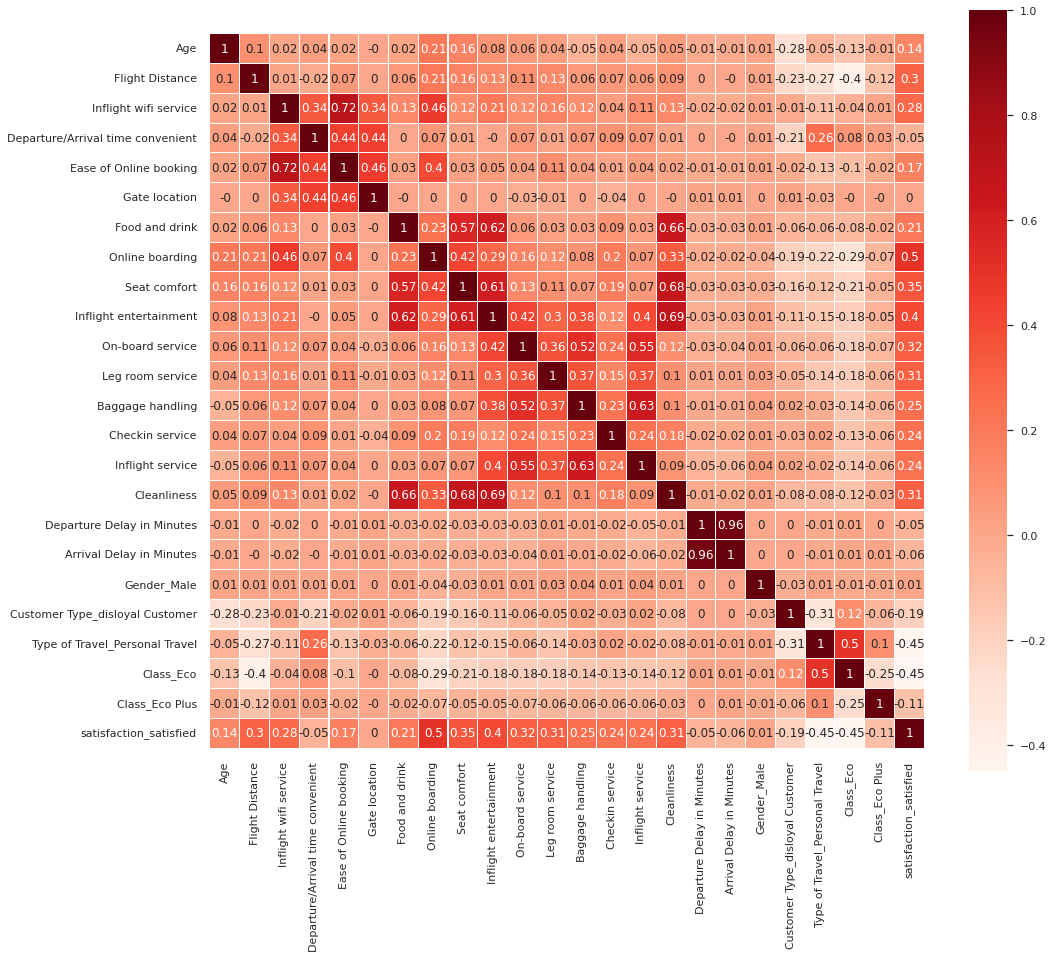

In [ ]:
#correlation plot
plt.figure(figsize=(16,14))
corr = train_d.corr().round(2)
corr
sns.heatmap(corr,annot=True,cmap=plt.cm.Reds,square = True,linewidth = 0.1)
plt.show()

---
# EDA: stats, EFA, PCA, MDS, Hierchical Clustering

##Exploratory Data Analysis (EDA)

###Look at Data

In [ ]:
df = pd.concat([train, test])
df.head()

Gender      Customer Type  Age   Type of Travel     Class  \
id                                                                  
70172     Male     Loyal Customer   13  Personal Travel  Eco Plus   
5047      Male  disloyal Customer   25  Business travel  Business   
110028  Female     Loyal Customer   26  Business travel  Business   
24026   Female     Loyal Customer   25  Business travel  Business   
119299    Male     Loyal Customer   61  Business travel  Business   

        Flight Distance  Inflight wifi service  \
id                                               
70172               460                      3   
5047                235                      3   
110028             1142                      2   
24026               562                      2   
119299              214                      3   

        Departure/Arrival time convenient  Ease of Online booking  \
id                                                                  
70172                                   4                       3   
5047                                    2                       3   
110028                                  2                       2   
24026                                   5                       5   
119299                                  3                       3   

        Gate location  ...  Inflight entertainment  On-board service  \
id                     ...                                             
70172               1  ...                       5                 4   
5047                3  ...                       1                 1   
110028              2  ...                       5                 4   
24026               5  ...                       2                 2   
119299              3  ...                       3                 3   

        Leg room service  Baggage handling  Checkin service  Inflight service  \
id                                                                              
70172                  3                 4                4                 5   
5047                   5                 3                1                 4   
110028                 3                 4                4                 4   
24026                  5                 3                1                 4   
119299                 4                 4                3                 3   

        Cleanliness  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                          
70172             5                          25                      18.0   
5047              1                           1                       6.0   
110028            5                           0                       0.0   
24026             2                          11                       9.0   
119299            3                           0                       0.0   

                   satisfaction  
id                               
70172   neutral or dissatisfied  
5047    neutral or dissatisfied  
110028                satisfied  
24026   neutral or dissatisfied  
119299                satisfied  

[5 rows x 23 columns]

In [ ]:
df.tail()

Gender      Customer Type  Age   Type of Travel     Class  \
id                                                                 
78463    Male  disloyal Customer   34  Business travel  Business   
71167    Male     Loyal Customer   23  Business travel  Business   
37675  Female     Loyal Customer   17  Personal Travel       Eco   
90086    Male     Loyal Customer   14  Business travel  Business   
34799  Female     Loyal Customer   42  Personal Travel       Eco   

       Flight Distance  Inflight wifi service  \
id                                              
78463              526                      3   
71167              646                      4   
37675              828                      2   
90086             1127                      3   
34799              264                      2   

       Departure/Arrival time convenient  Ease of Online booking  \
id                                                                 
78463                                  3                       3   
71167                                  4                       4   
37675                                  5                       1   
90086                                  3                       3   
34799                                  5                       2   

       Gate location  ...  Inflight entertainment  On-board service  \
id                    ...                                             
78463              1  ...                       4                 3   
71167              4  ...                       4                 4   
37675              5  ...                       2                 4   
90086              3  ...                       4                 3   
34799              5  ...                       1                 1   

       Leg room service  Baggage handling  Checkin service  Inflight service  \
id                                                                             
78463                 2                 4                4                 5   
71167                 5                 5                5                 5   
37675                 3                 4                5                 4   
90086                 2                 5                4                 5   
34799                 2                 1                1                 1   

       Cleanliness  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                         
78463            4                           0                       0.0   
71167            4                           0                       0.0   
37675            2                           0                       0.0   
90086            4                           0                       0.0   
34799            1                           0                       0.0   

                  satisfaction  
id                              
78463  neutral or dissatisfied  
71167                satisfied  
37675  neutral or dissatisfied  
90086                satisfied  
34799  neutral or dissatisfied  

[5 rows x 23 columns]

In [ ]:
df.shape

(129880, 23)

In [ ]:
df.size

2987240

In [ ]:
df['Gender'].value_counts()

Female    65899
Male      63981
Name: Gender, dtype: int64

In [ ]:
df['Customer Type'].value_counts()

Loyal Customer       106100
disloyal Customer     23780
Name: Customer Type, dtype: int64

In [ ]:
df['Class'].value_counts()

Business    62160
Eco         58309
Eco Plus     9411
Name: Class, dtype: int64

In [ ]:
df['Type of Travel'].value_counts()

Business travel    89693
Personal Travel    40187
Name: Type of Travel, dtype: int64

In [ ]:
df['satisfaction'].value_counts()

neutral or dissatisfied    73452
satisfied                  56428
Name: satisfaction, dtype: int64

### Bivariate analysis

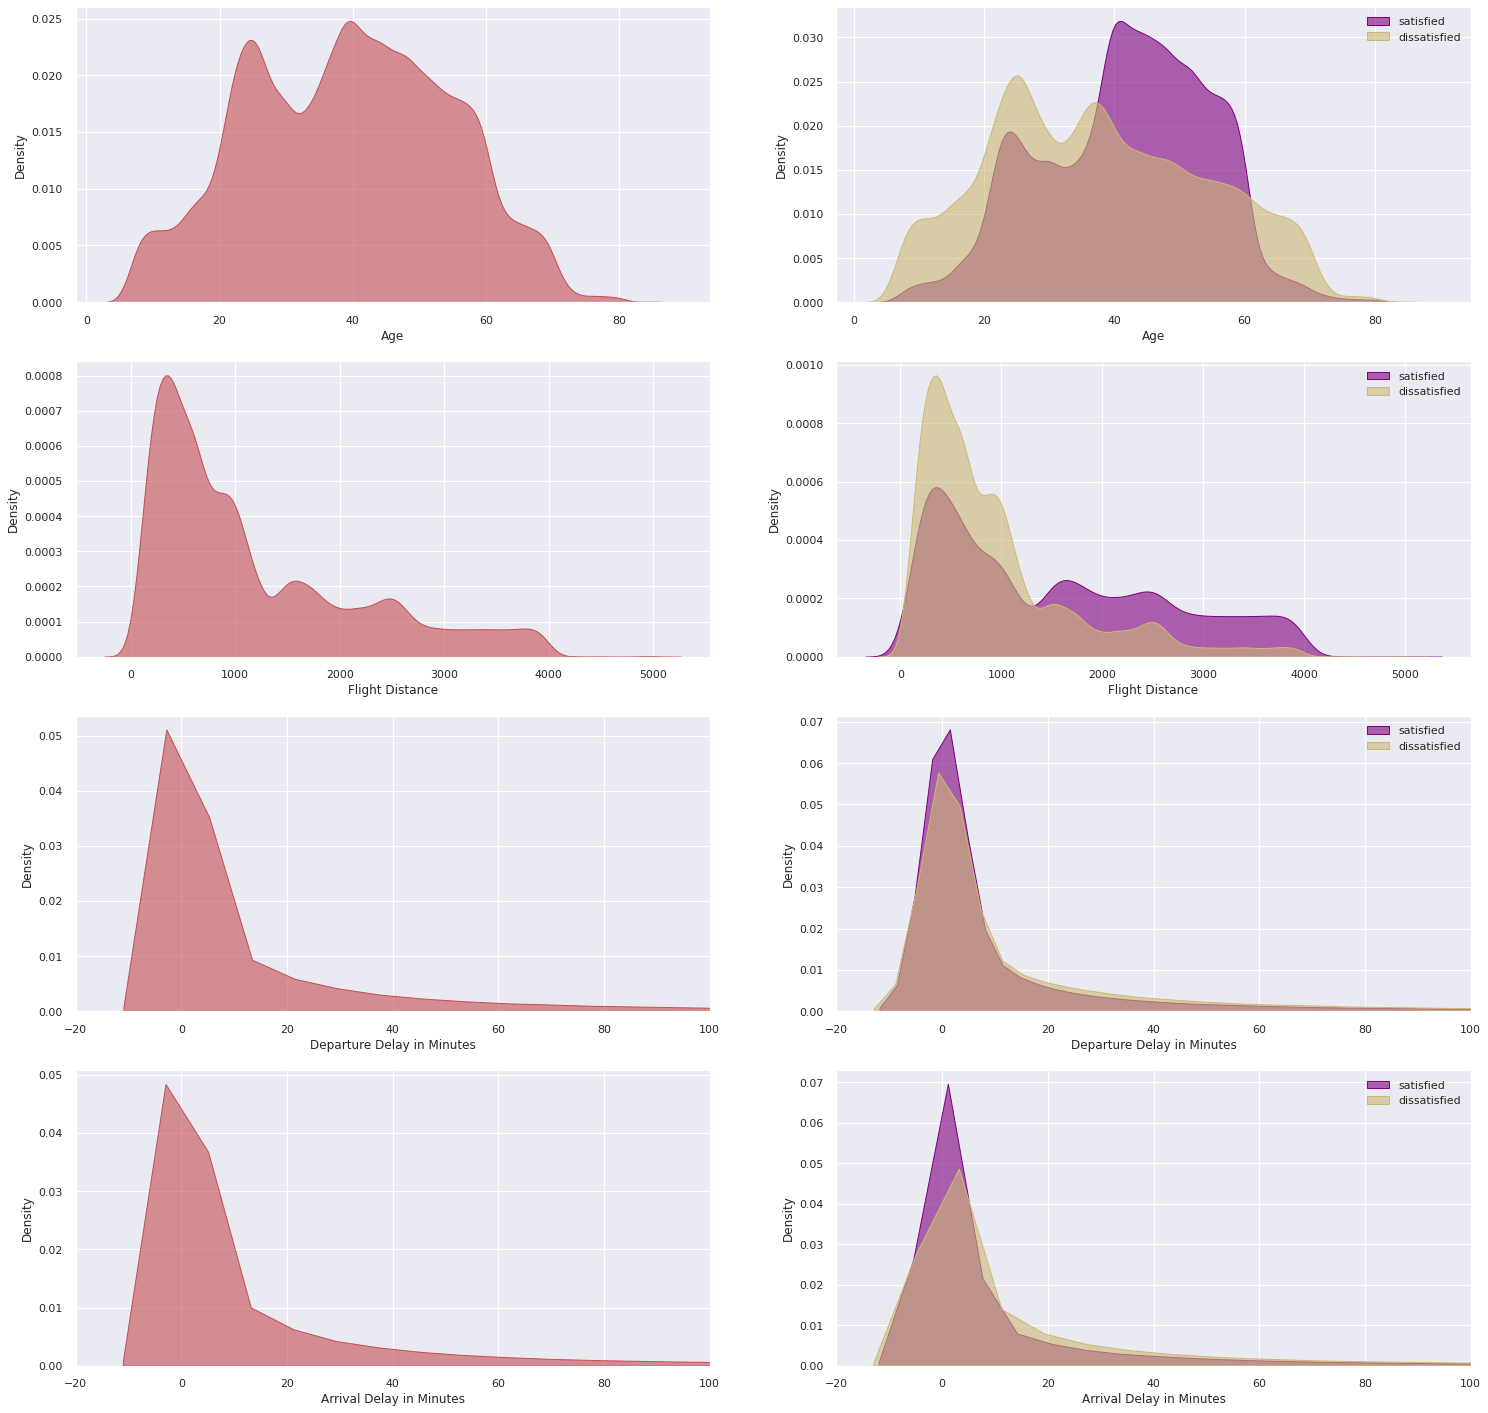

In [ ]:
#plot between satisfaction and continous varaible to see if there is relationship
def draw_kde_plot(column, **kvargs):
    sns.set(style="darkgrid")
    sns.kdeplot(
        column, 
        shade=True, 
        alpha=0.6,
        **kvargs
    )
def draw_comparative_kde_plot(satisfied_column, dissatisfied_column, xlim=None, **kwargs):
    sns.set(style="darkgrid")
    fig = sns.kdeplot(
        satisfied_column, 
        shade=True, 
        alpha=0.6, 
        color="purple", 
        **kwargs)
    
    fig = sns.kdeplot(
        dissatisfied_column, 
        shade=True, 
        alpha=0.6, 
        color="y", 
        **kwargs)
    
    fig.legend(labels=['satisfied', 'dissatisfied'])

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(25, 25))
ax = ax.ravel()

satisfied = df[df['satisfaction'] == 'satisfied']
dissatisfied = df[df['satisfaction'] == 'neutral or dissatisfied']

draw_kde_plot(df['Age'], ax=ax[0], color='r')
draw_comparative_kde_plot(satisfied['Age'], dissatisfied['Age'], ax=ax[1])

draw_kde_plot(df['Flight Distance'], ax=ax[2], color='r')
draw_comparative_kde_plot(satisfied['Flight Distance'], dissatisfied['Flight Distance'], ax=ax[3])

draw_kde_plot(df['Departure Delay in Minutes'], ax=ax[4], color='r')
draw_comparative_kde_plot(satisfied['Departure Delay in Minutes'], dissatisfied['Departure Delay in Minutes'], ax=ax[5], gridsize=400)
ax[4].set_xlim(-20, 100)
ax[5].set_xlim(-20, 100)

draw_kde_plot(df['Arrival Delay in Minutes'], ax=ax[6], color='r')
draw_comparative_kde_plot(satisfied['Arrival Delay in Minutes'], dissatisfied['Arrival Delay in Minutes'], ax=ax[7])
ax[6].set_xlim(-20, 100)
ax[7].set_xlim(-20, 100)

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

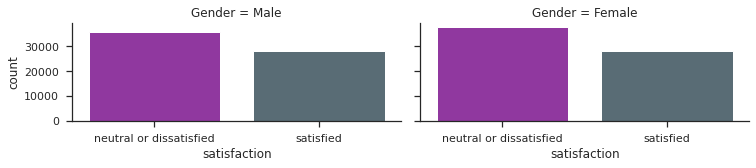

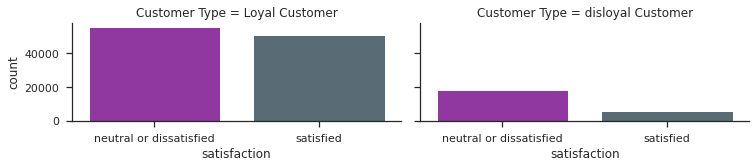

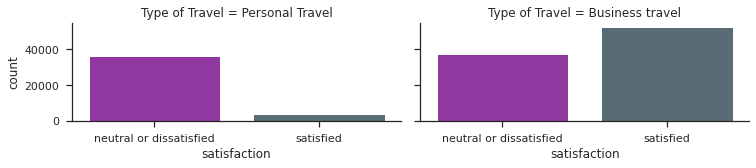

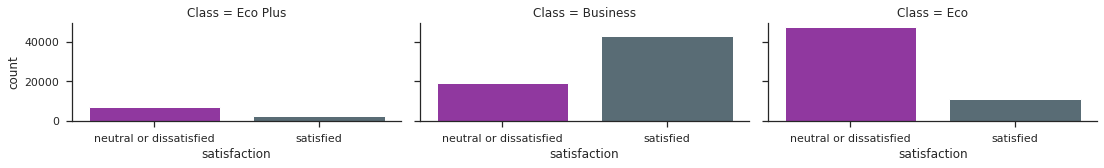

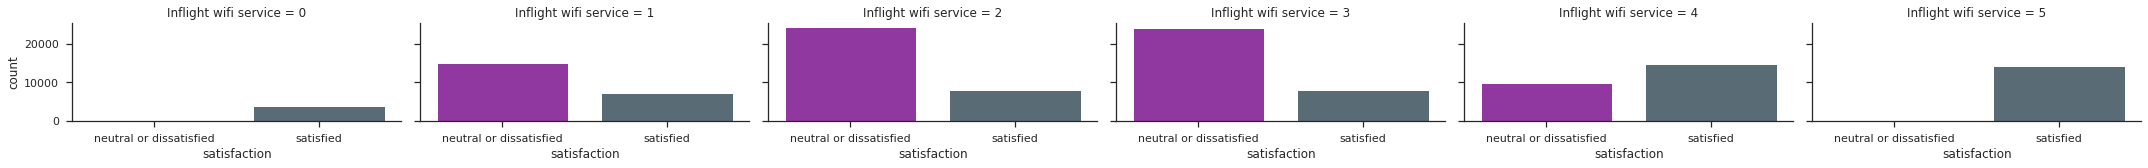

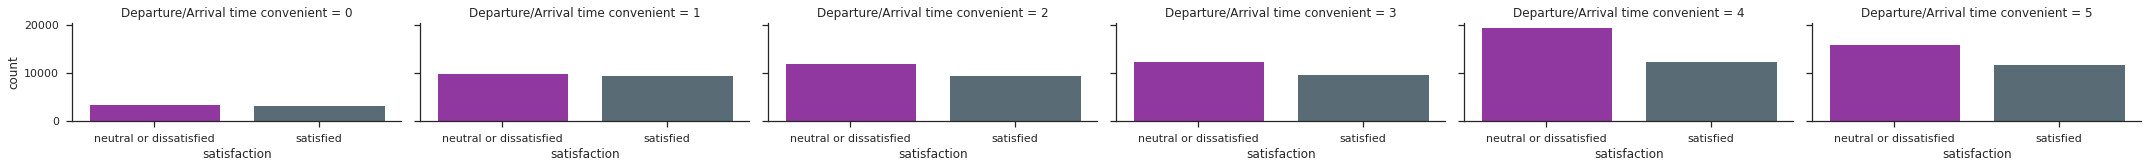

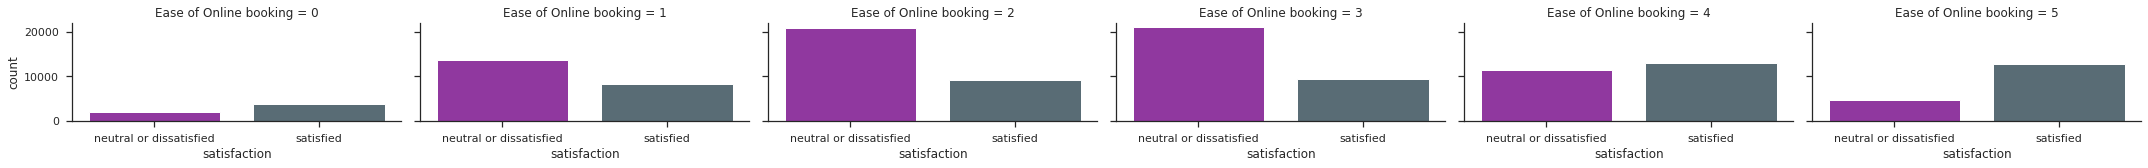

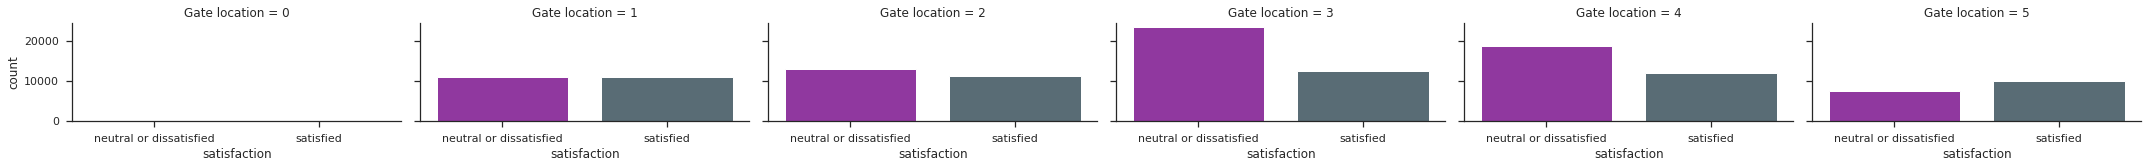

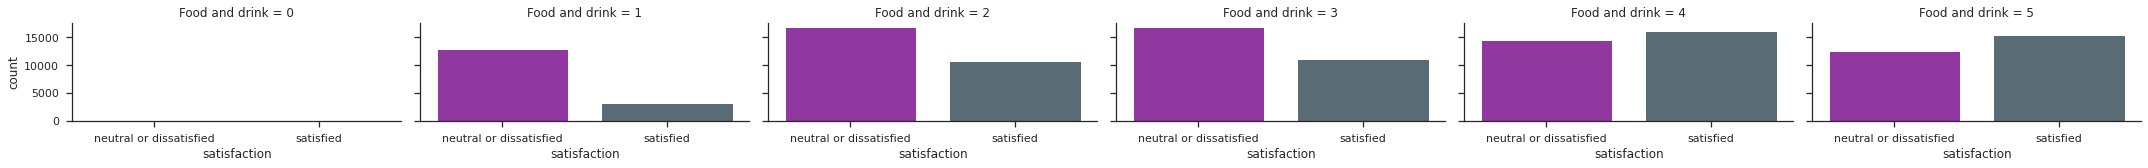

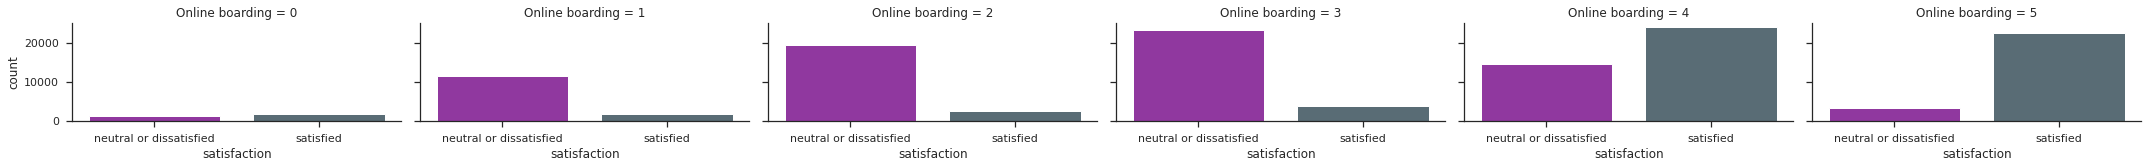

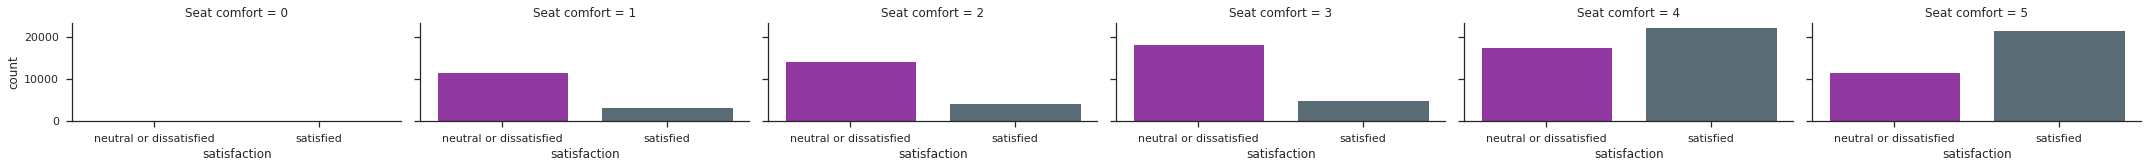

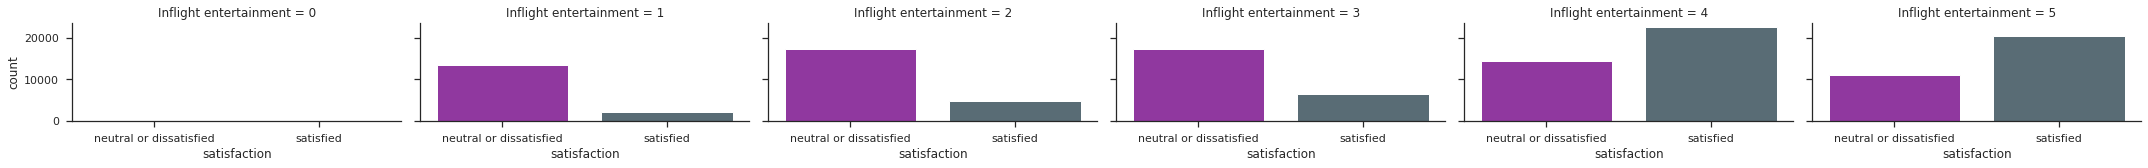

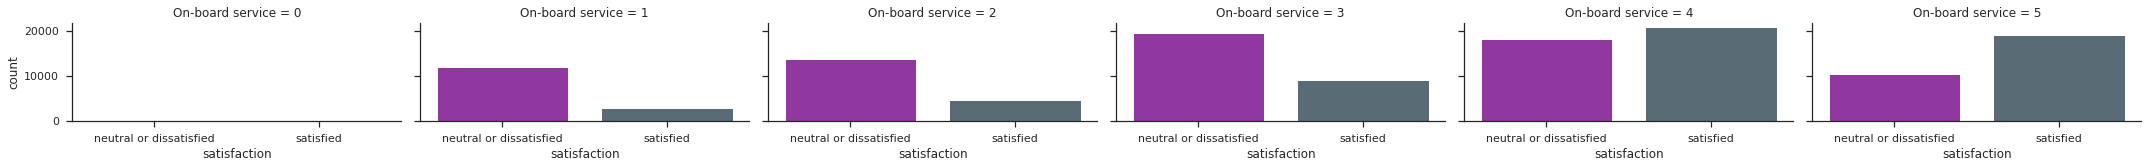

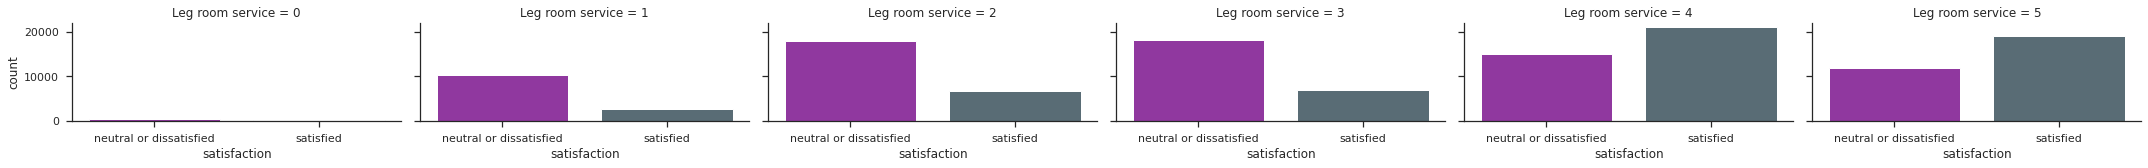

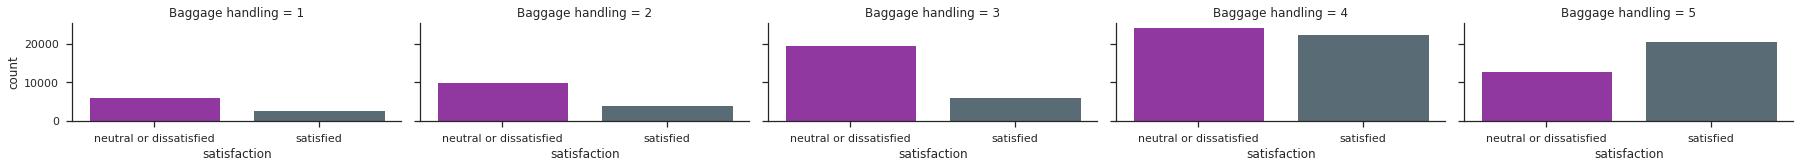

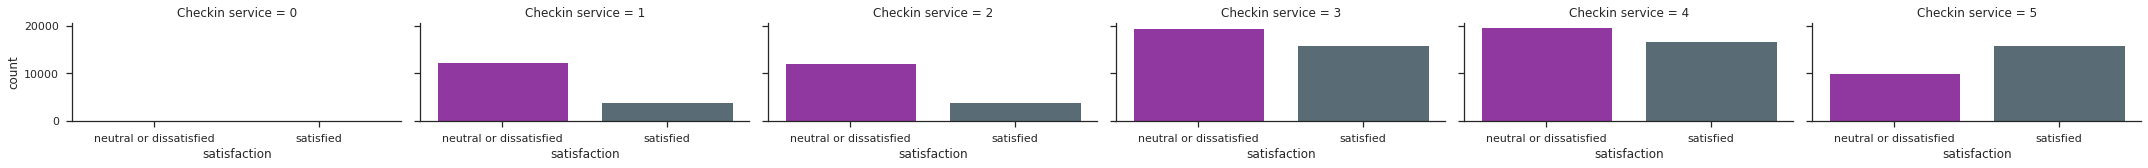

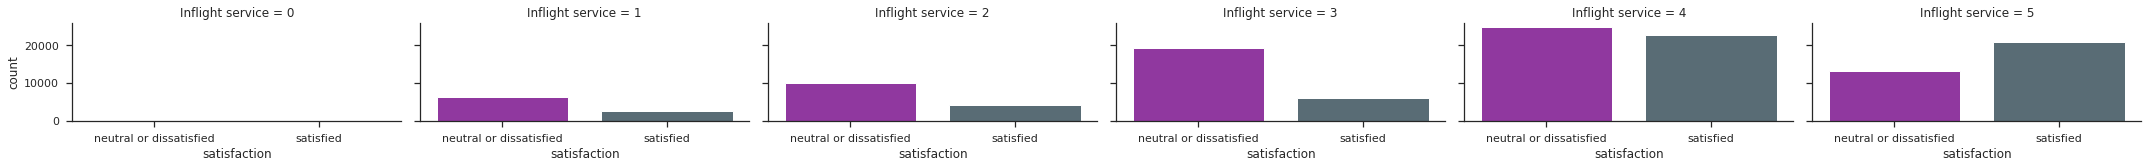

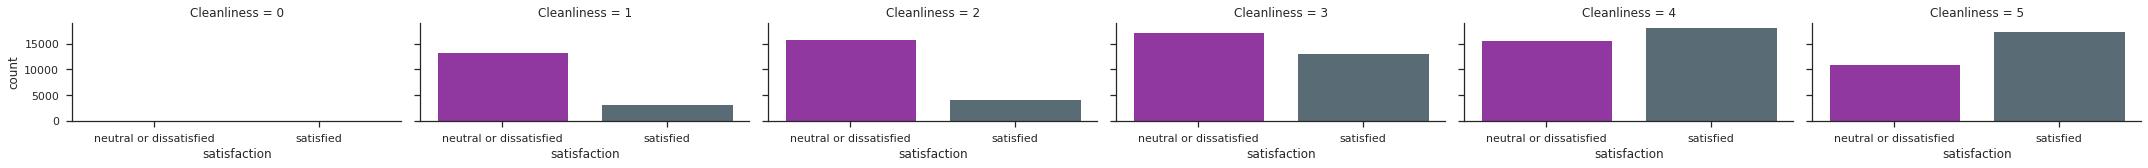

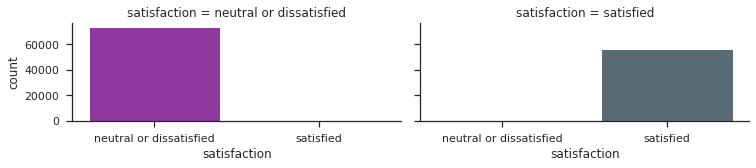

In [ ]:
pal = ["#9c27b0", "#546e7a","#00b8d4"]
with sns.axes_style(style='ticks'):
  temp=df.drop(columns=['Age','Flight Distance','Departure Delay in Minutes','Arrival Delay in Minutes'])
  for i in range(len(temp.columns)):
    g = sns.catplot("satisfaction", col=temp.columns[i], col_wrap=6, data=temp, kind="count", height=2.5, aspect=2.0,palette=pal)  


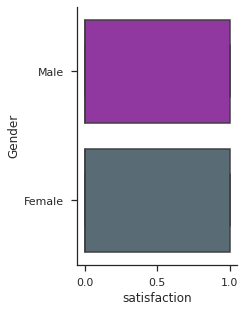

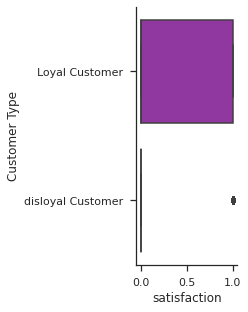

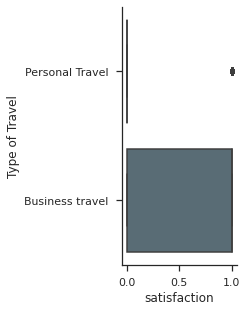

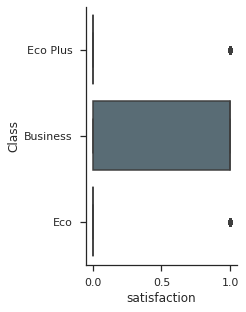

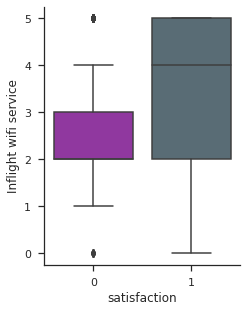

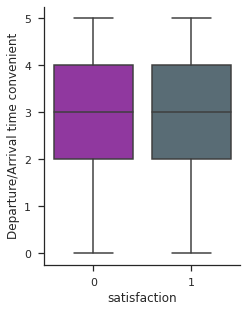

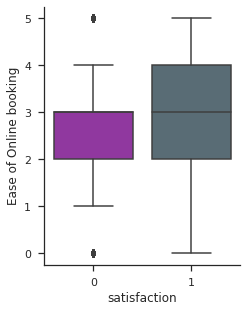

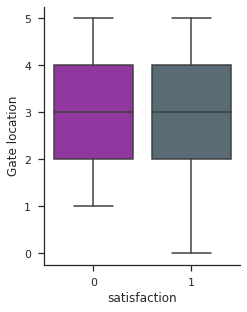

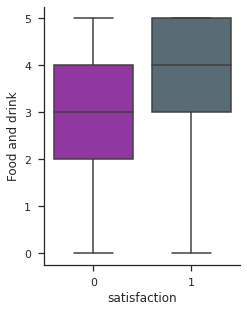

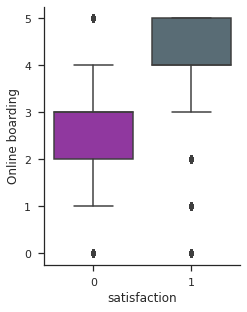

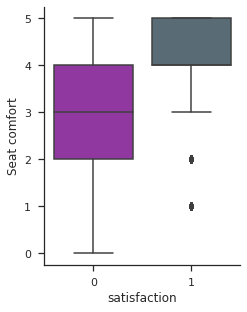

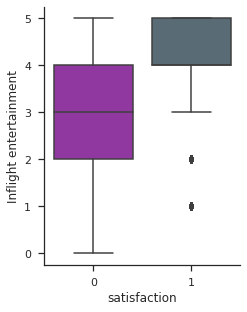

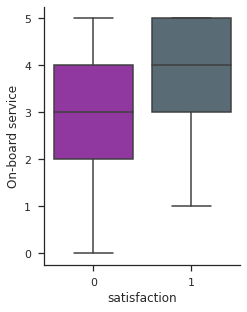

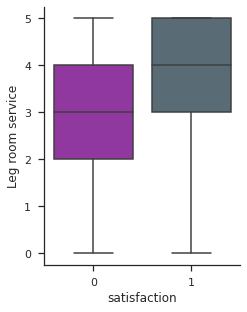

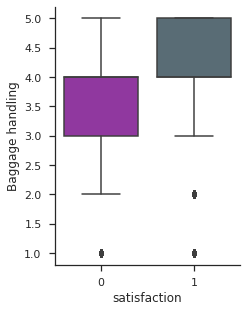

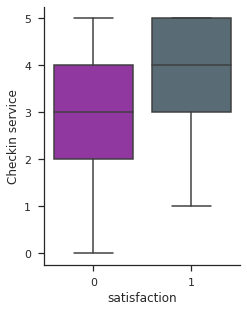

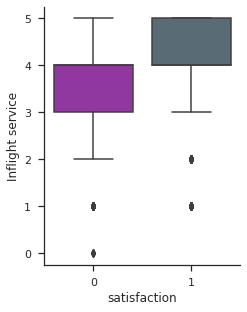

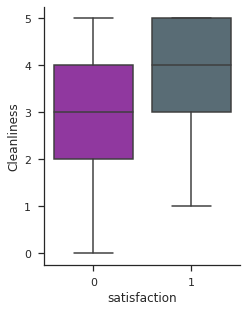

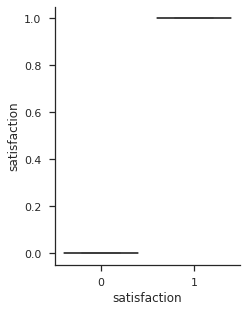

In [ ]:
pal = ["#9c27b0", "#546e7a","#00b8d4"]
df['satisfaction'].replace({'neutral or dissatisfied': 0, 'satisfied': 1},inplace = True)
with sns.axes_style(style='ticks'):
  temp=df.drop(columns=['Age','Flight Distance','Departure Delay in Minutes','Arrival Delay in Minutes'])
  for i in range(len(temp.columns)):
     g = sns.catplot(x="satisfaction", y=temp.columns[i], data=temp, kind="box", height=4.5, aspect=.8,palette=pal) 

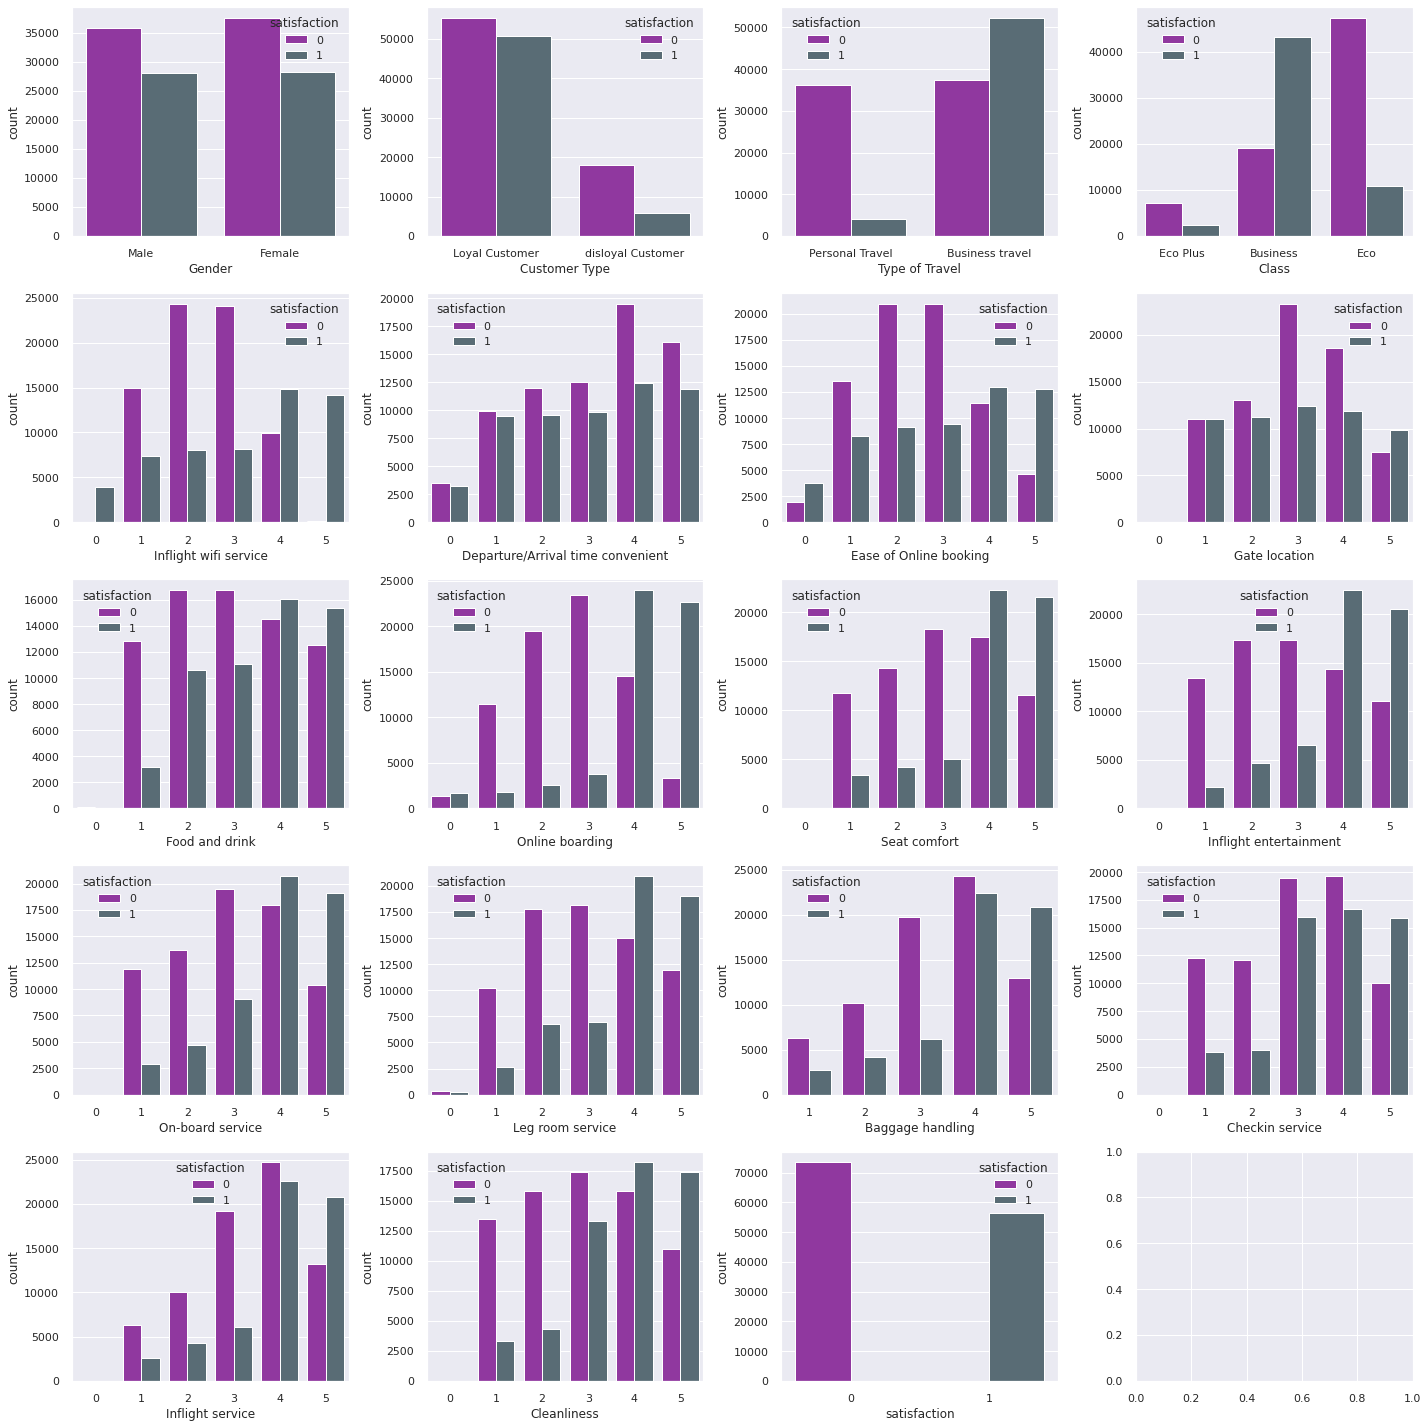

In [ ]:
pal = ["#9c27b0", "#546e7a","#00b8d4"]
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))
axs = axs.ravel()
temp=df.drop(columns=['Age','Flight Distance','Departure Delay in Minutes','Arrival Delay in Minutes'])
i=0
for col in temp.columns:
    
    # define location
    plt.subplot(5, 4, i+1)
    
    # create plot
    ax = plt.gca()
    axs[i] = sns.countplot(x = col, hue = 'satisfaction', data = temp,palette=pal)
    
   
    i += 1    

plt.tight_layout()
plt.show()

###Multivariate Analysis

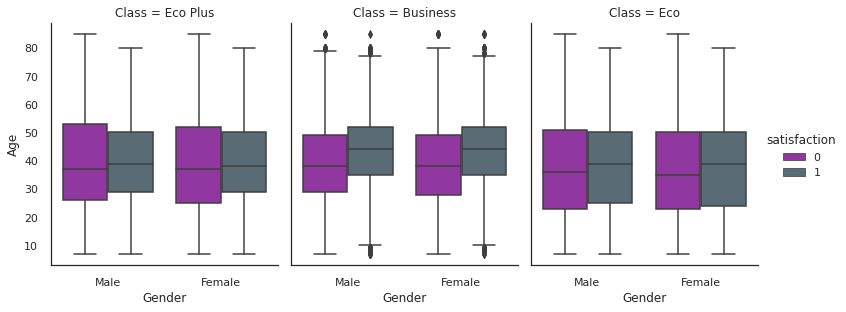

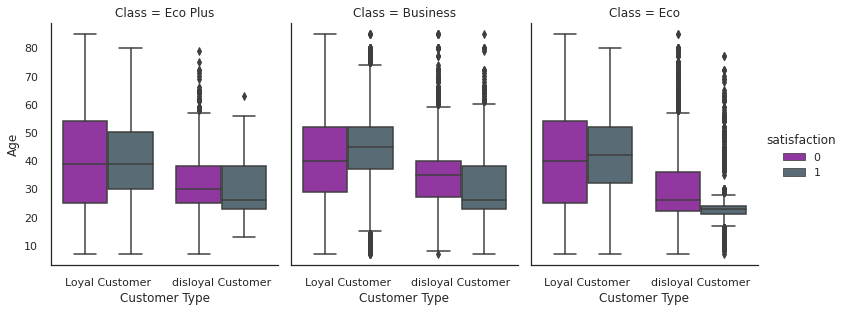

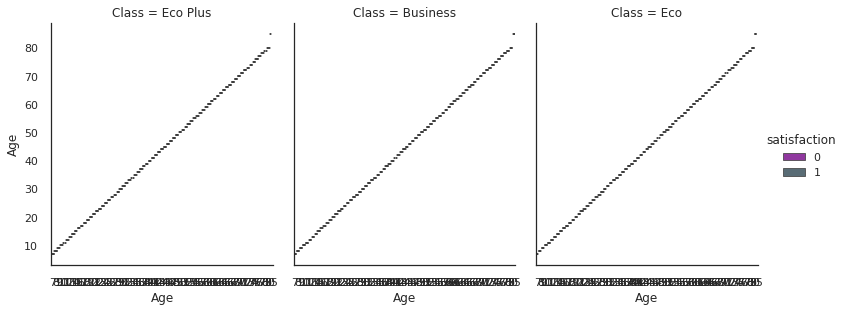

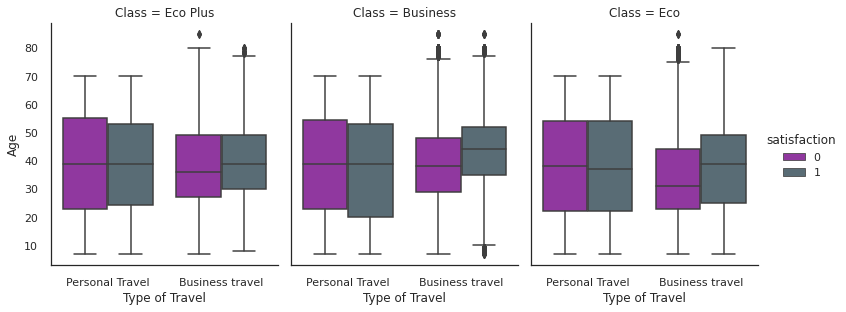

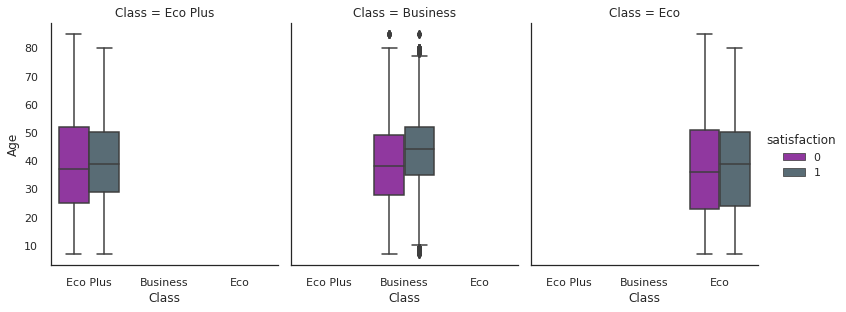

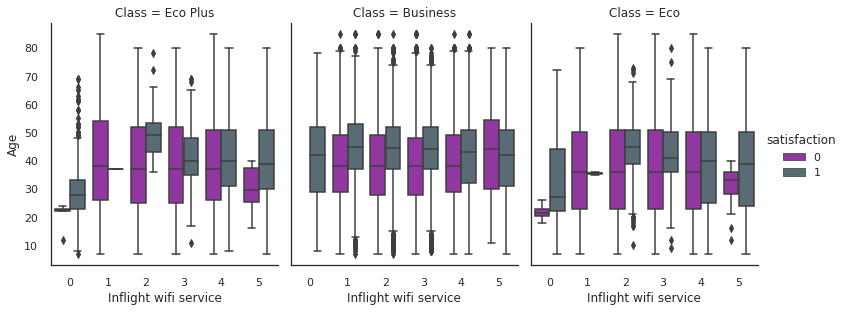

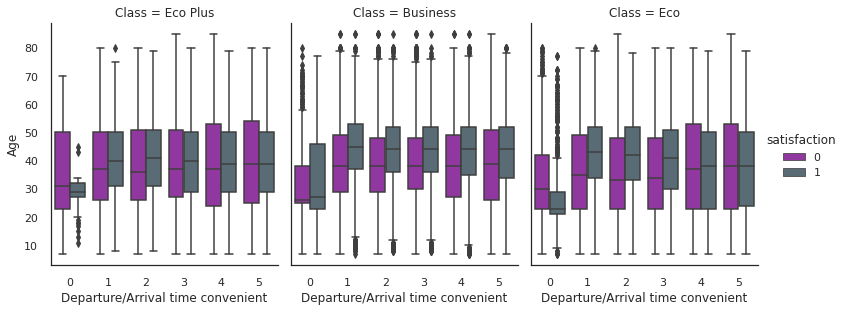

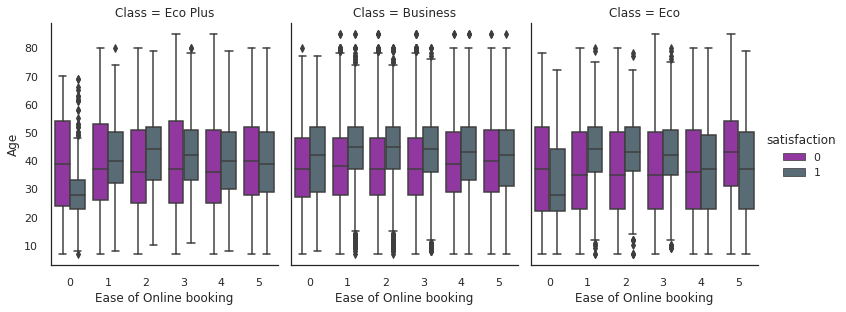

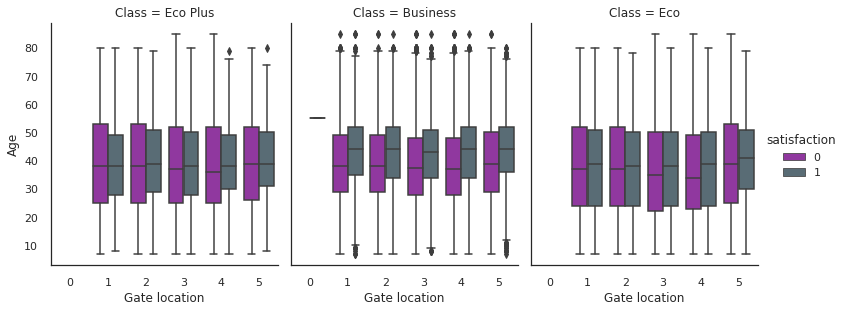

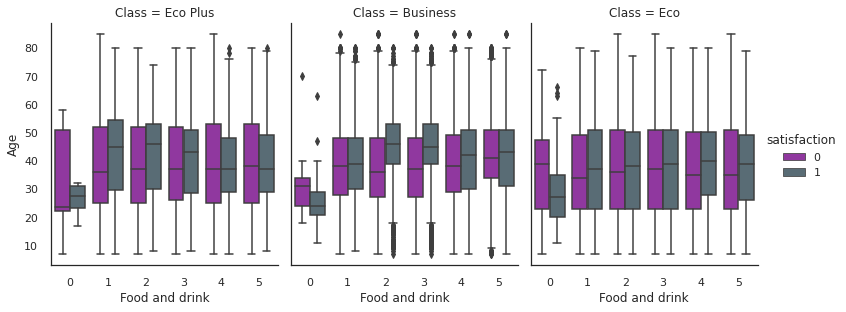

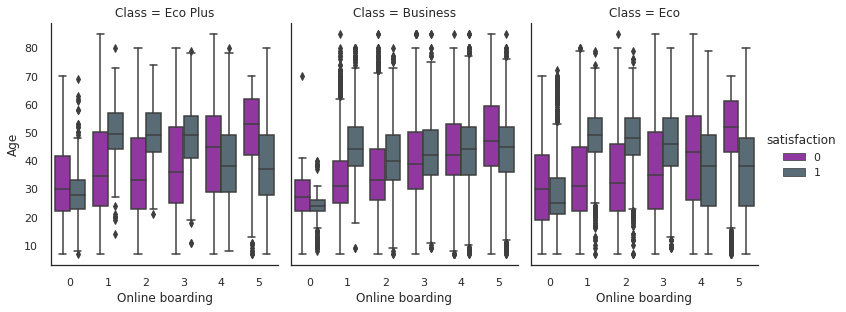

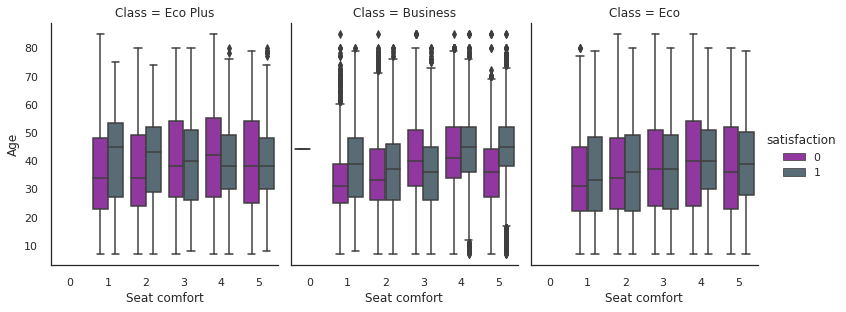

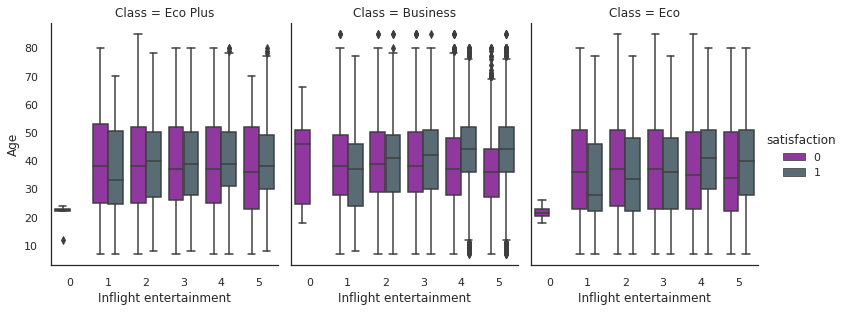

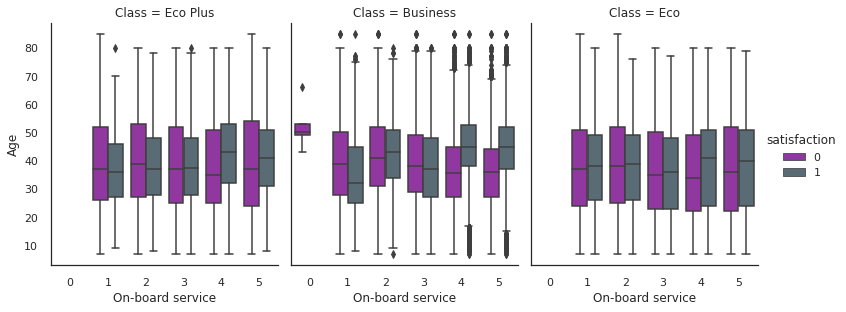

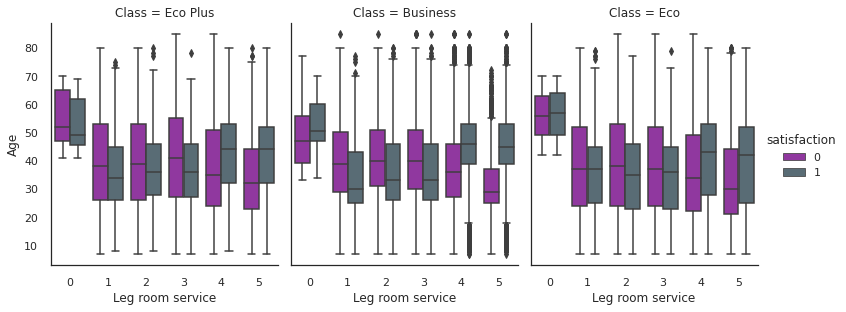

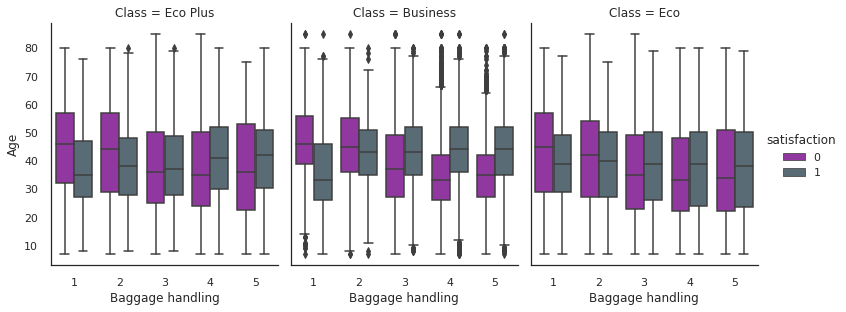

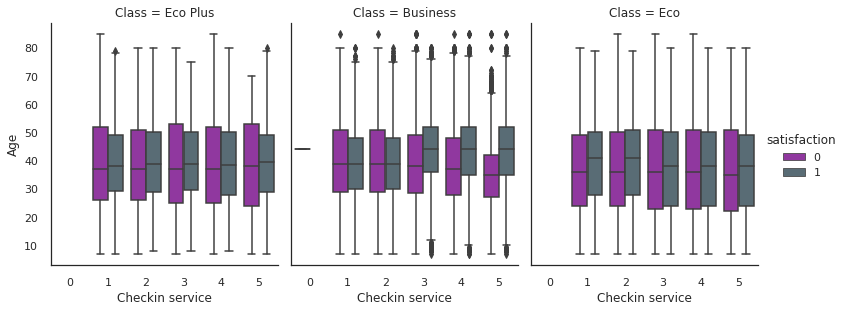

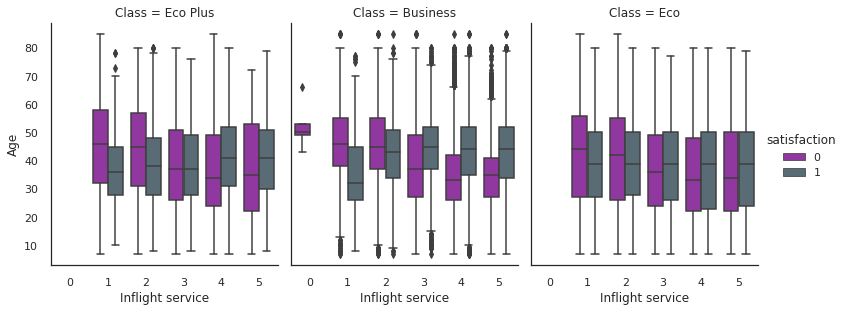

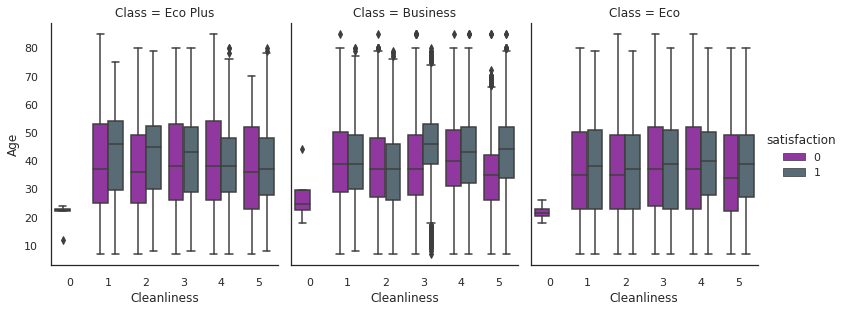

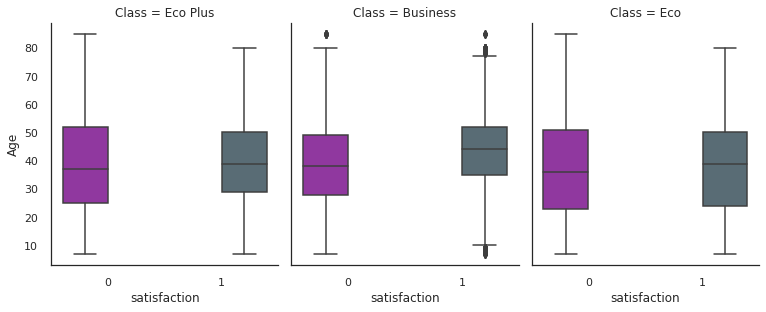

In [ ]:
pal = ["#9c27b0", "#546e7a","#00b8d4"]
temp=df.drop(columns=['Flight Distance','Departure Delay in Minutes','Arrival Delay in Minutes'])
with sns.axes_style('white'):
    for i in range(len(temp.columns)):
      g = sns.catplot(x=temp.columns[i], y="Age", hue="satisfaction", col="Class", data=temp, kind="box", height=4.5, aspect=.8,palette=pal)

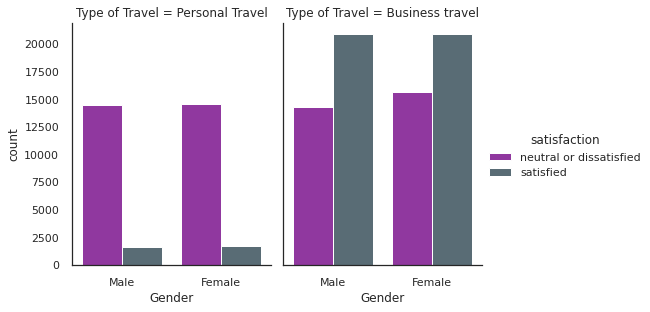

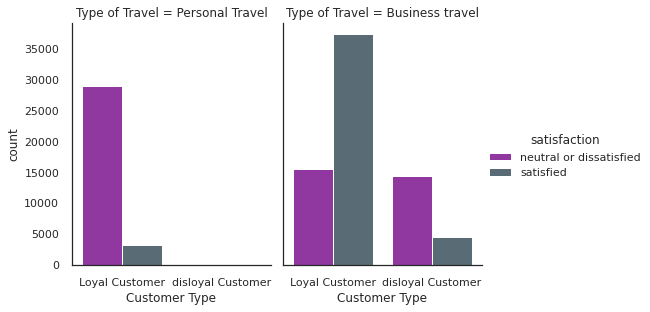

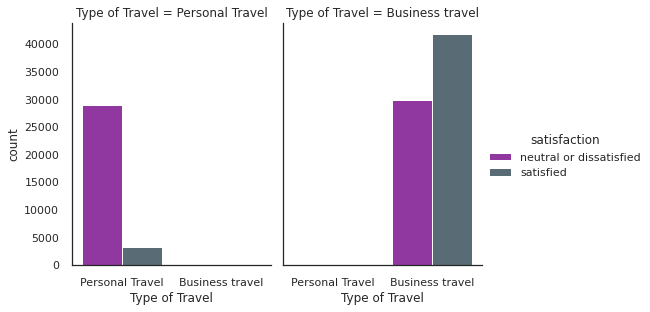

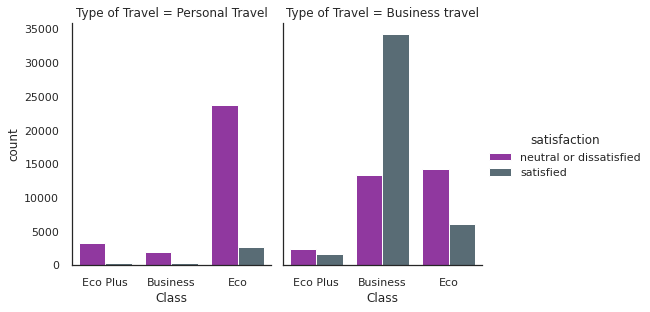

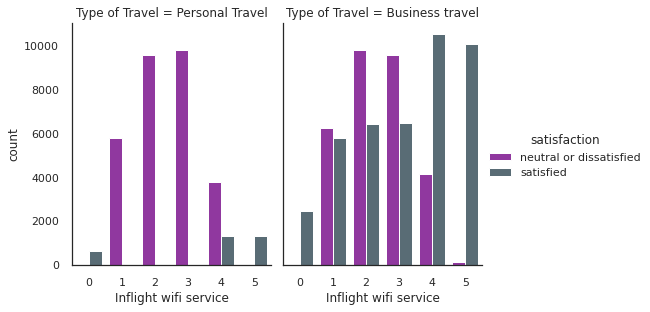

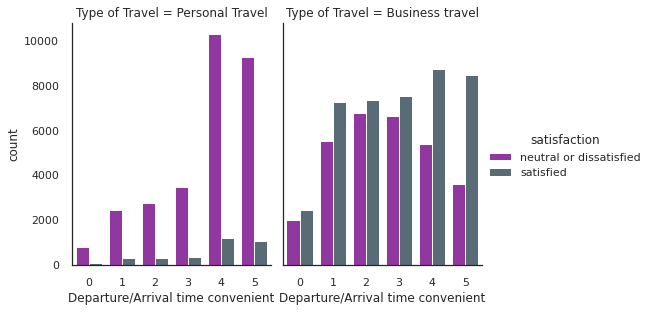

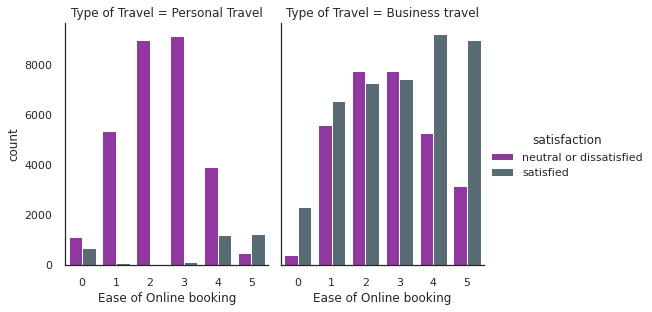

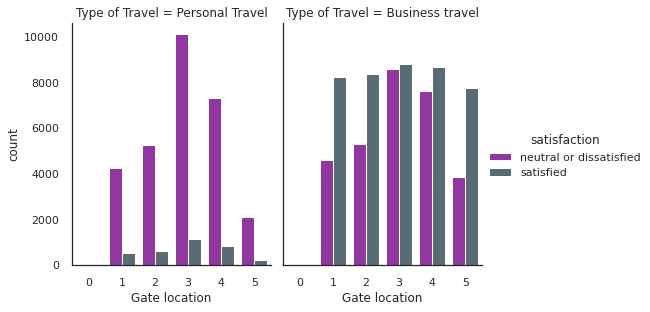

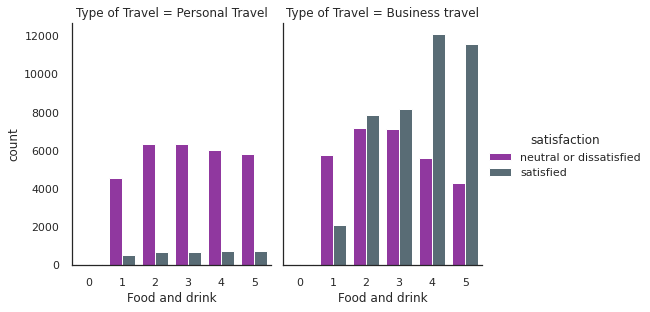

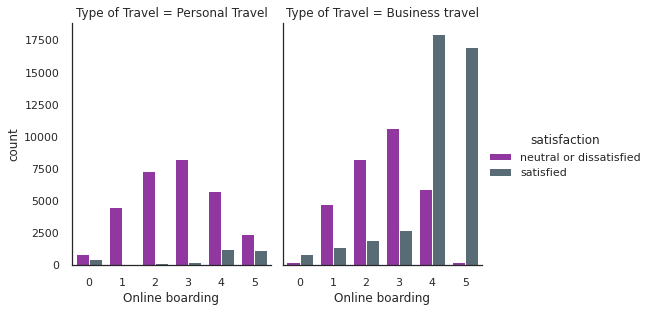

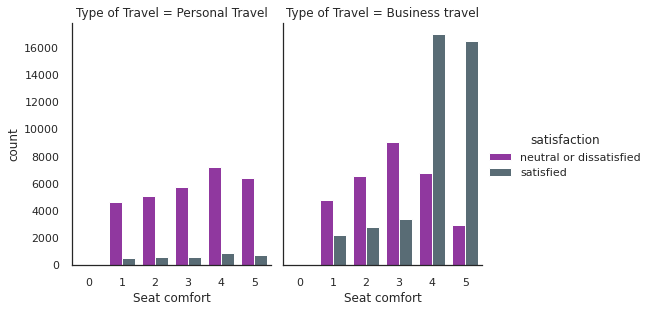

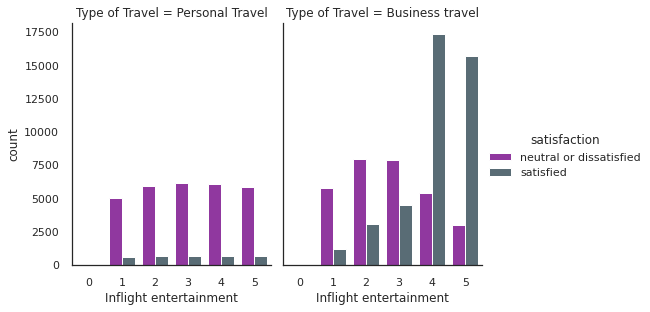

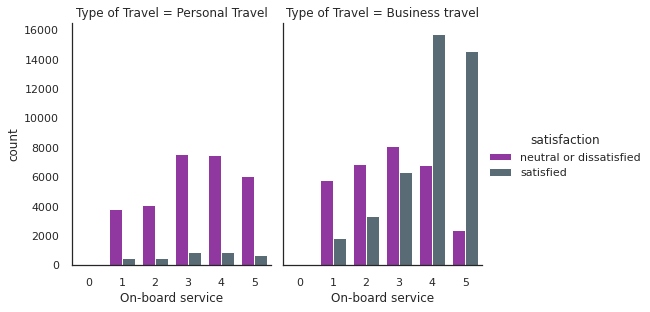

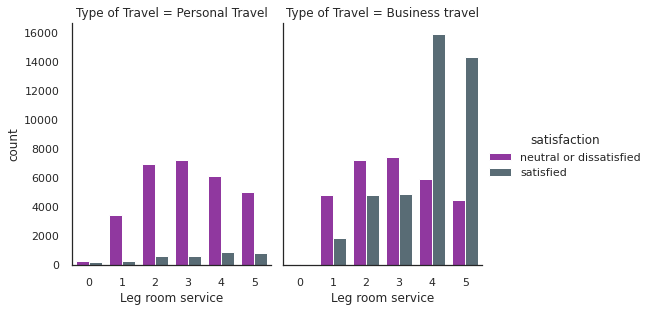

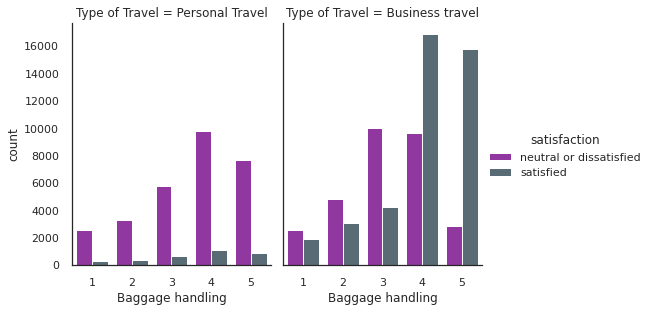

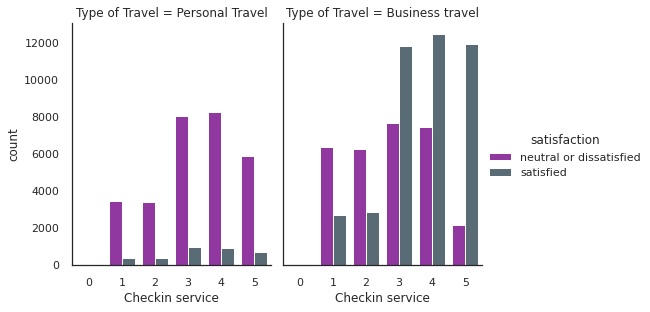

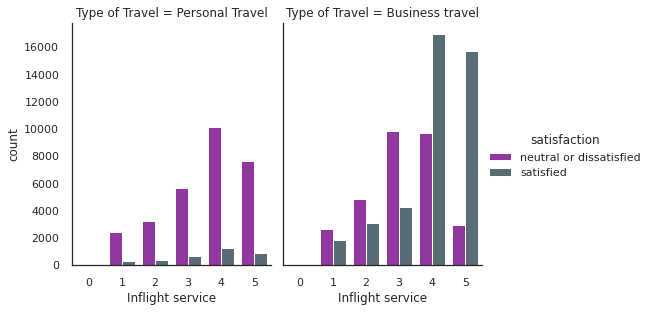

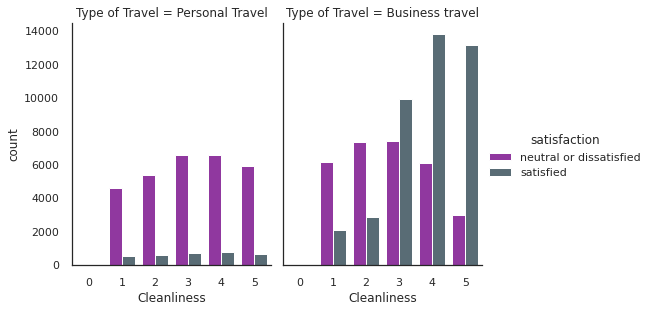

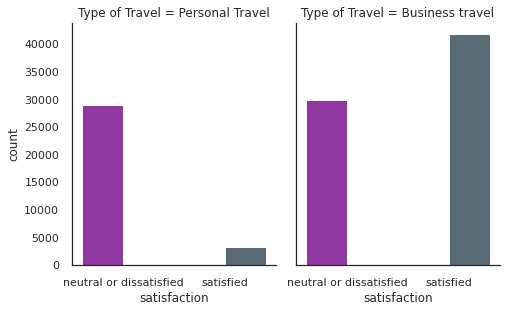

In [ ]:
pal = ["#9c27b0", "#546e7a","#00b8d4"]
temp=df.drop(columns=['Age','Flight Distance','Departure Delay in Minutes','Arrival Delay in Minutes'])
with sns.axes_style('white'):
  for i in range(len(temp.columns)):
    g = sns.catplot(x=temp.columns[i], hue="satisfaction", col="Type of Travel", data=train, kind="count", height=4.5, aspect=.8,palette=pal)

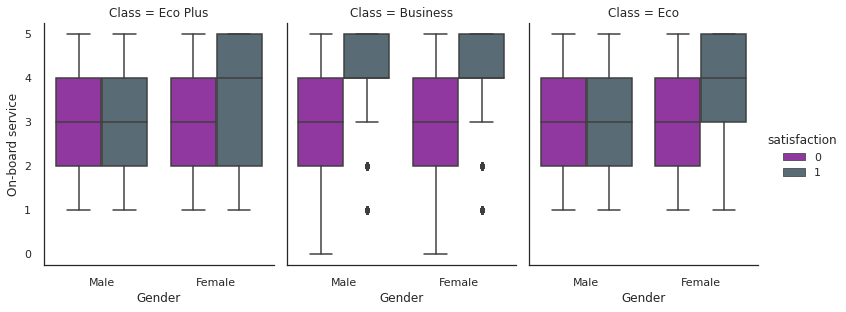

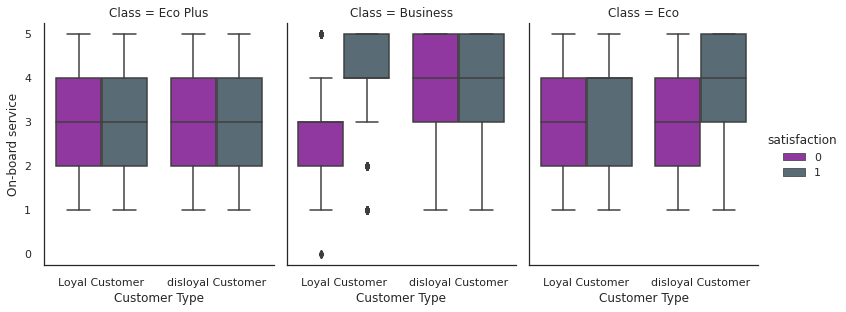

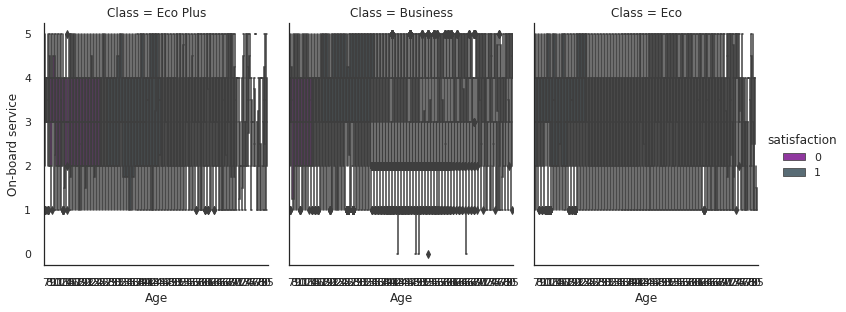

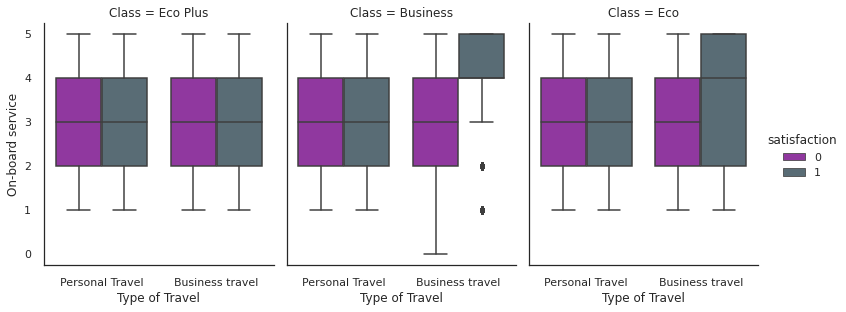

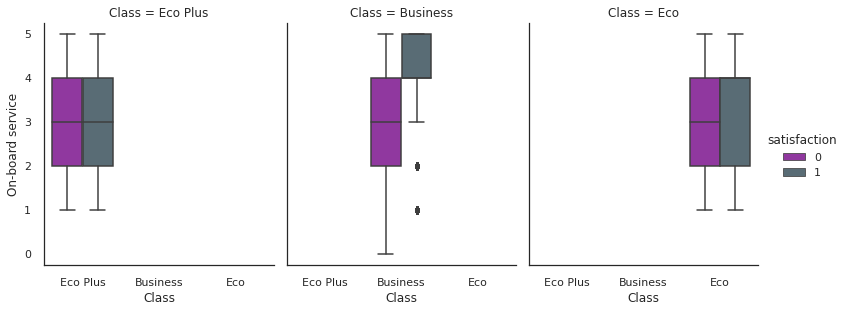

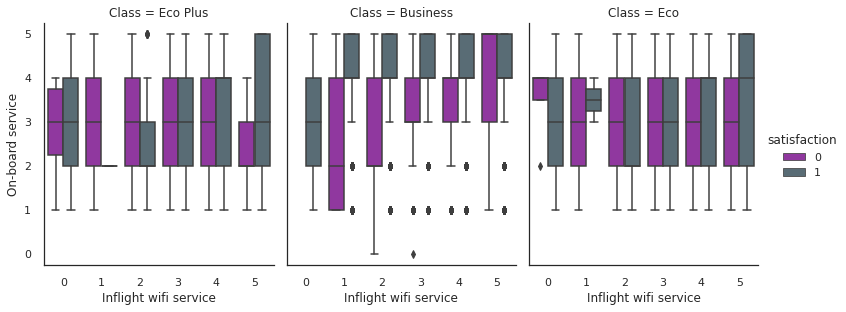

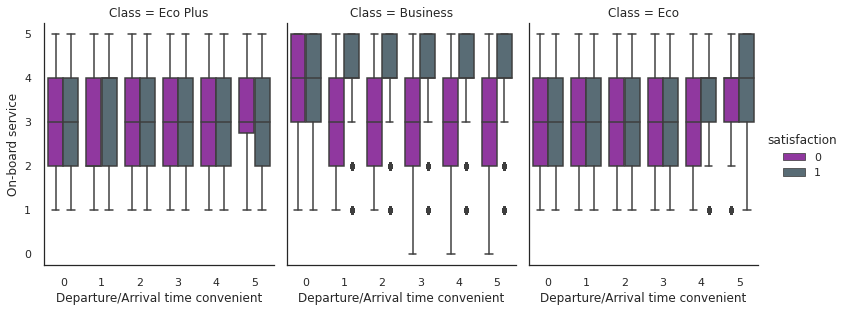

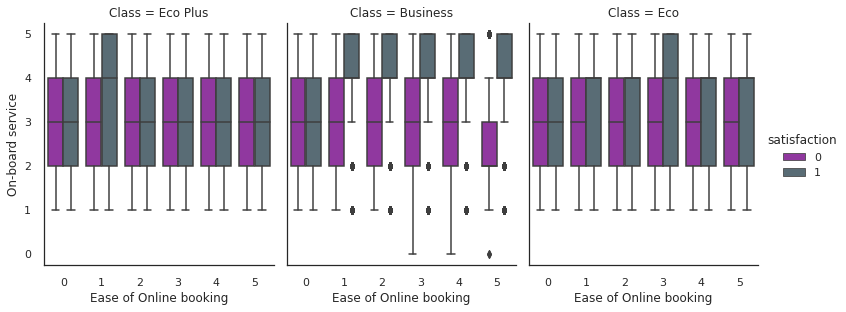

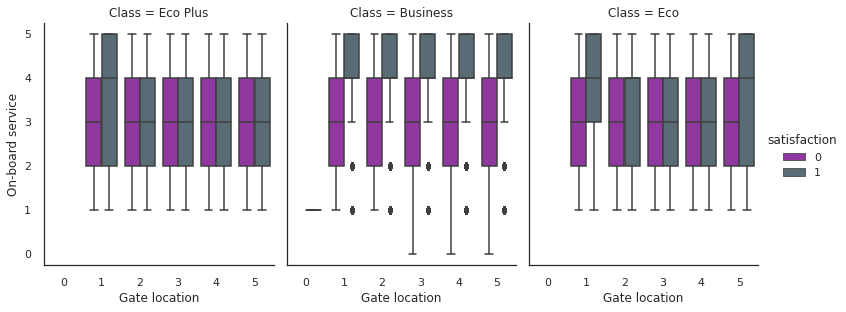

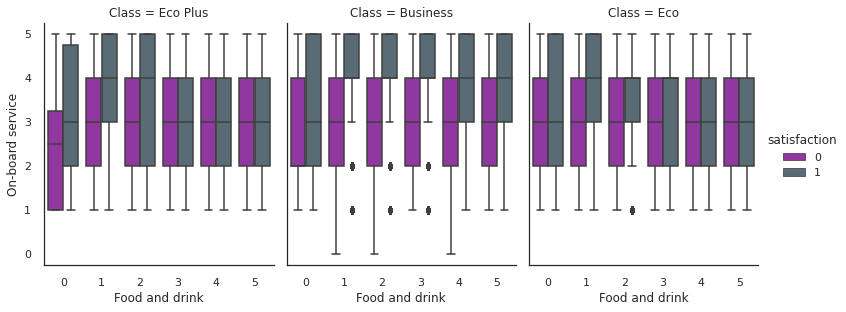

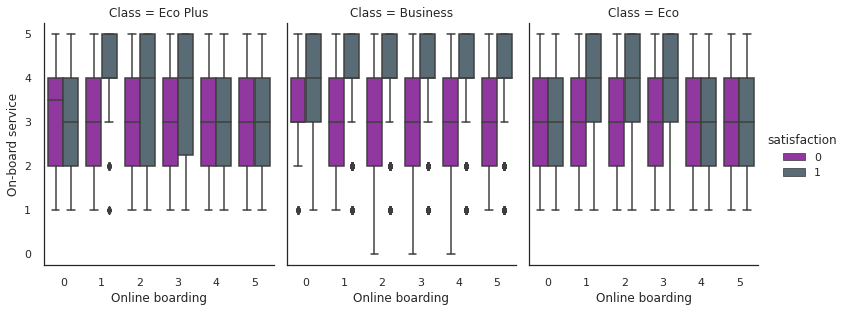

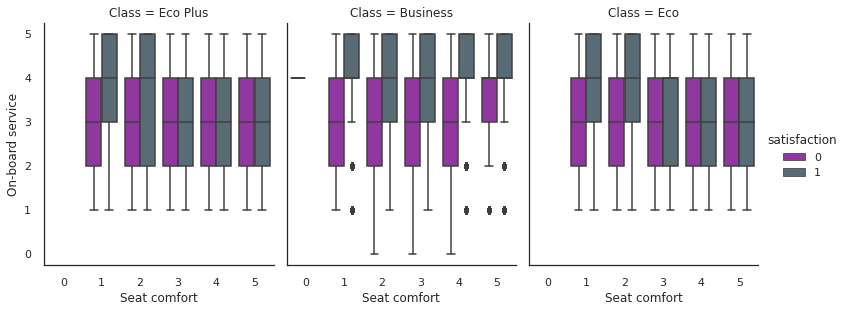

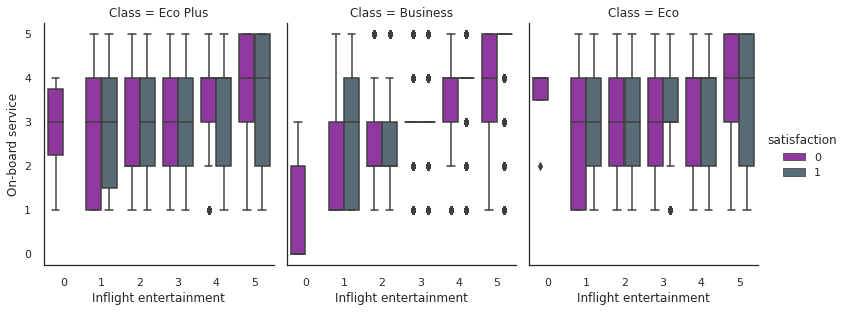

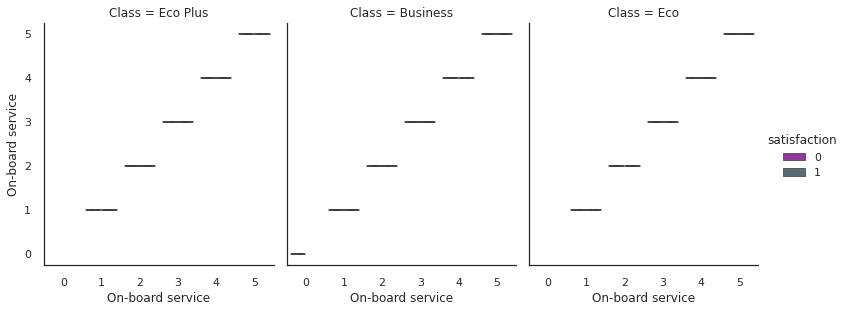

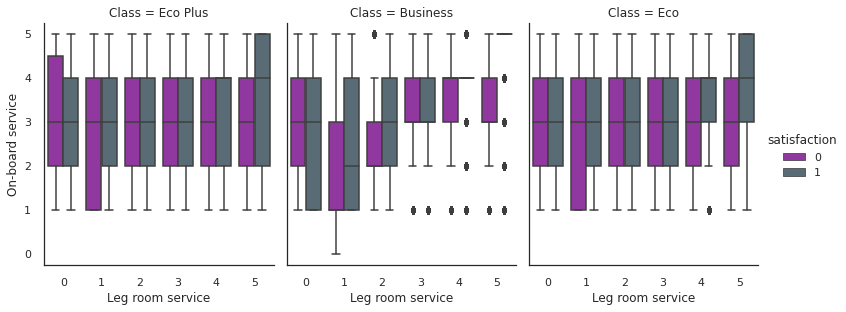

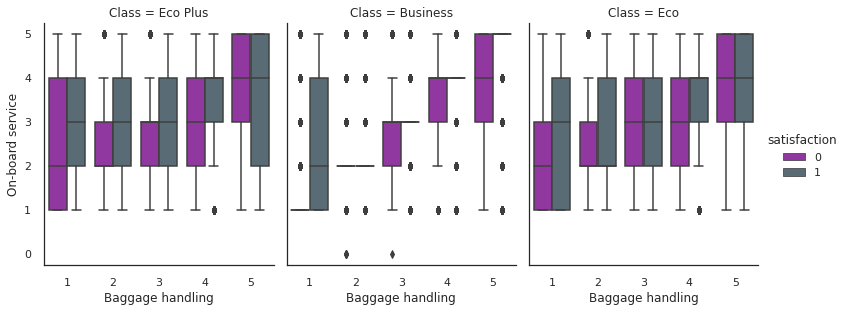

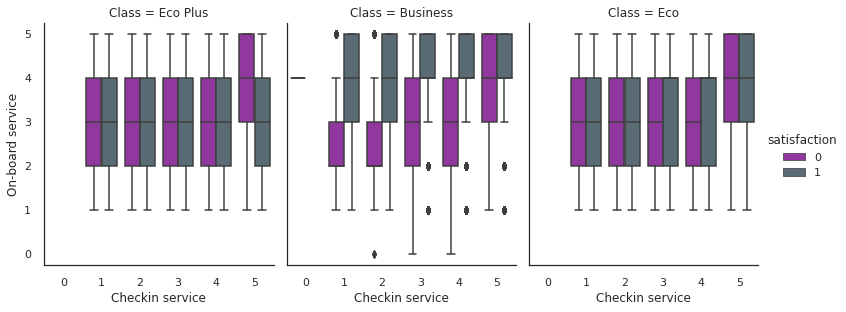

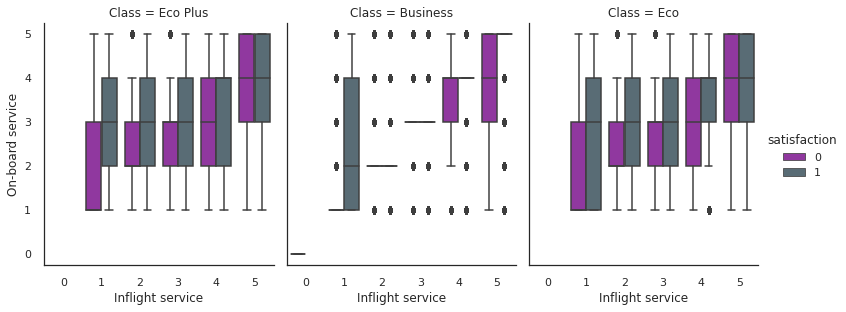

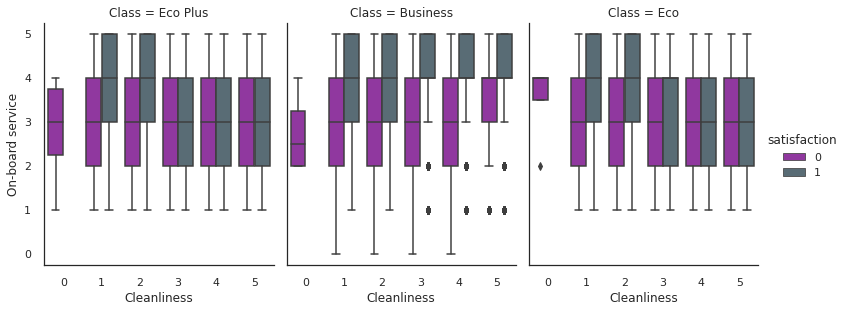

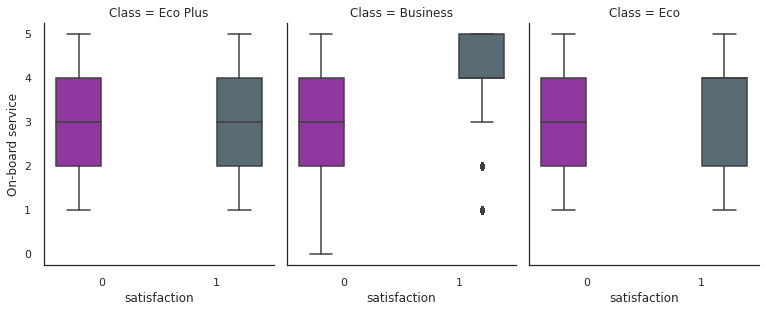

In [ ]:
pal = ["#9c27b0", "#546e7a","#00b8d4"]
temp=df.drop(columns=['Flight Distance','Departure Delay in Minutes','Arrival Delay in Minutes'])
with sns.axes_style('white'):
    for i in range(len(temp.columns)):
      g = sns.catplot(x=temp.columns[i], y="On-board service", hue="satisfaction", col="Class", data=temp, kind="box", height=4.5, aspect=.8,palette=pal)

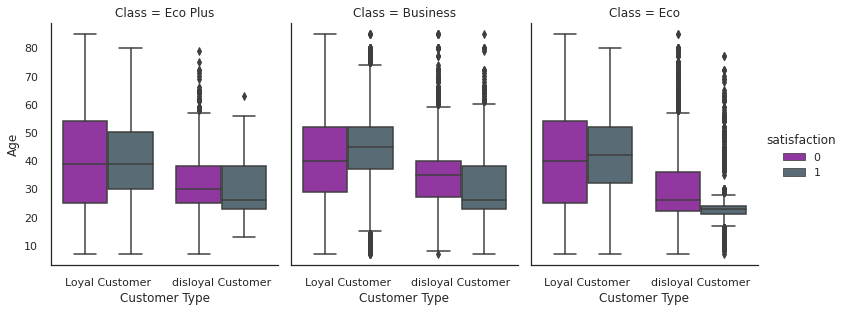

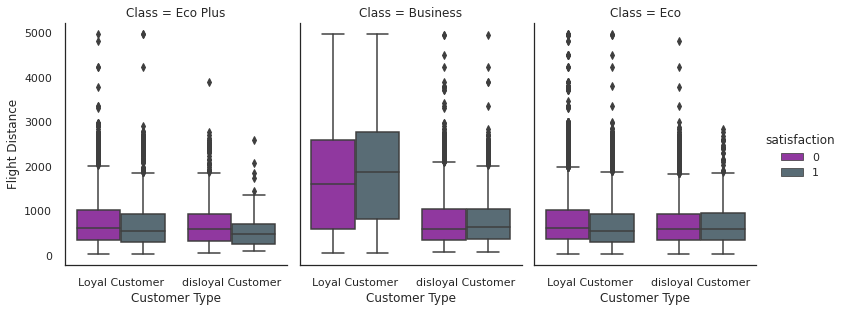

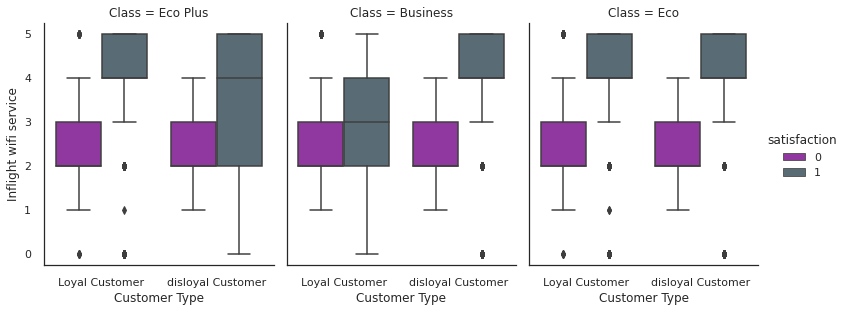

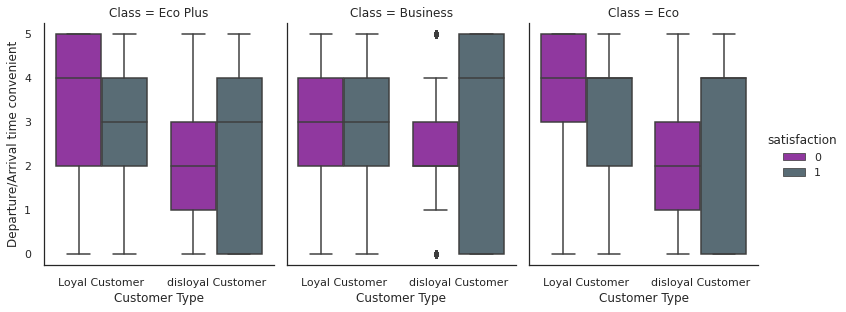

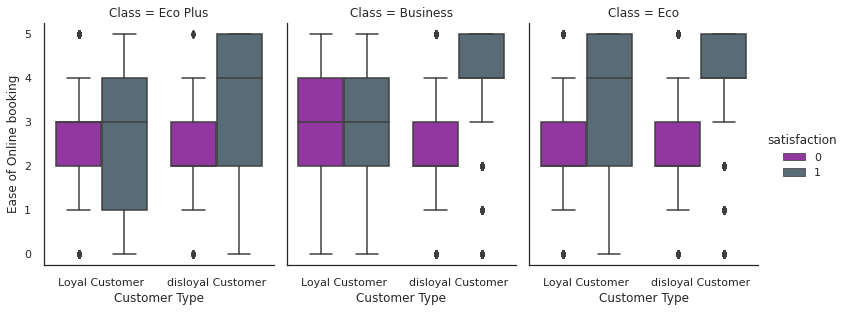

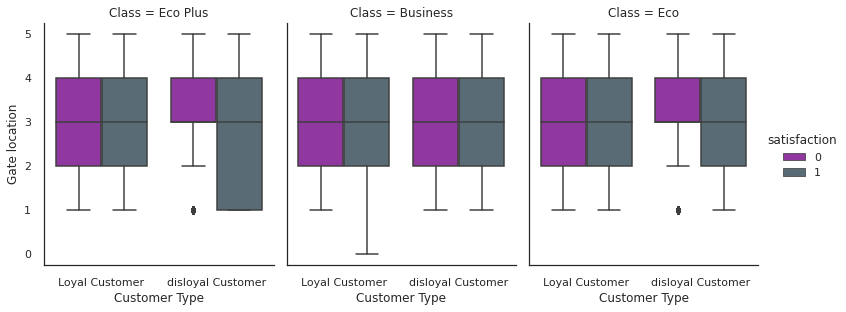

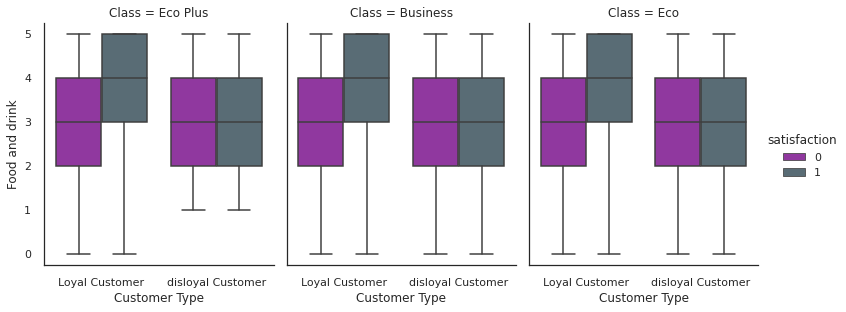

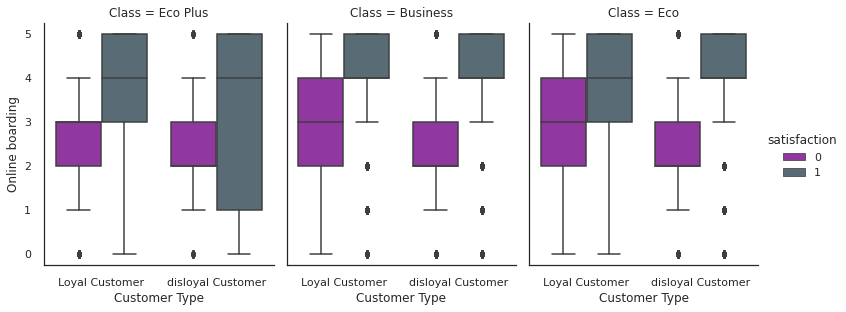

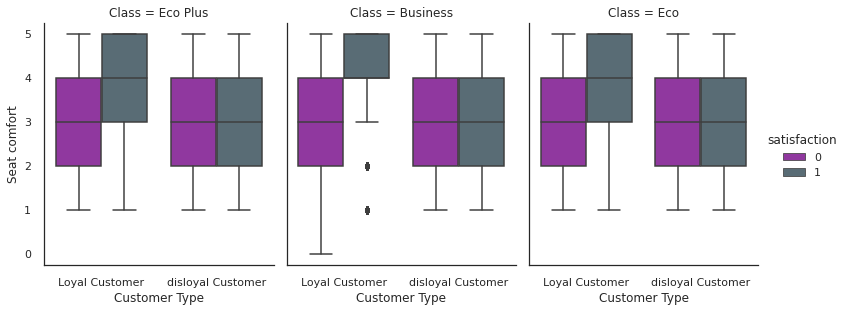

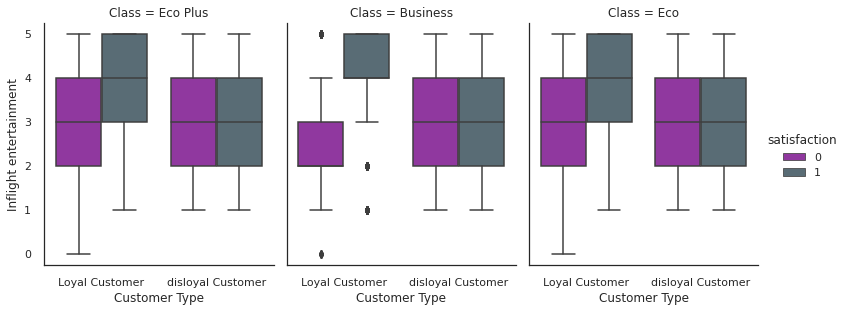

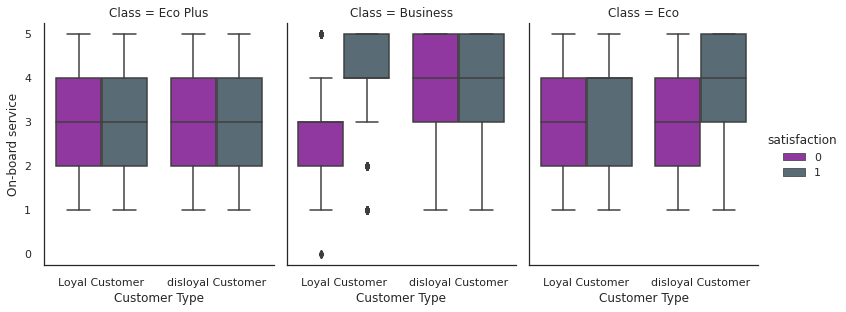

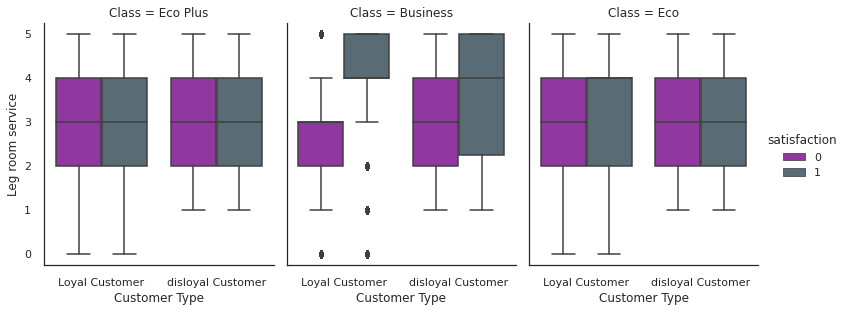

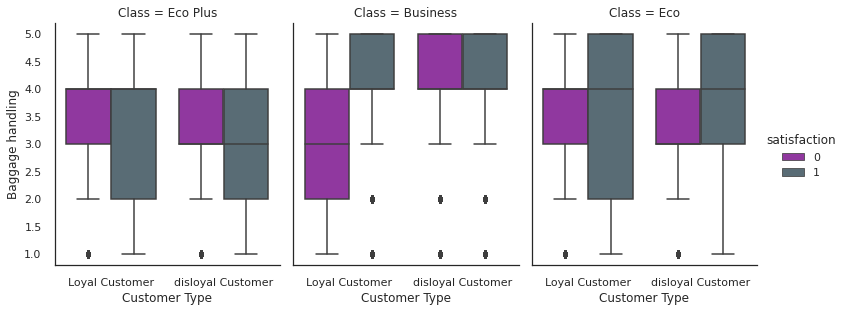

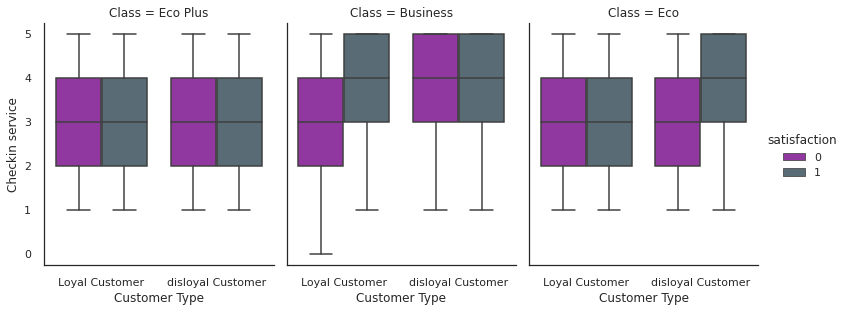

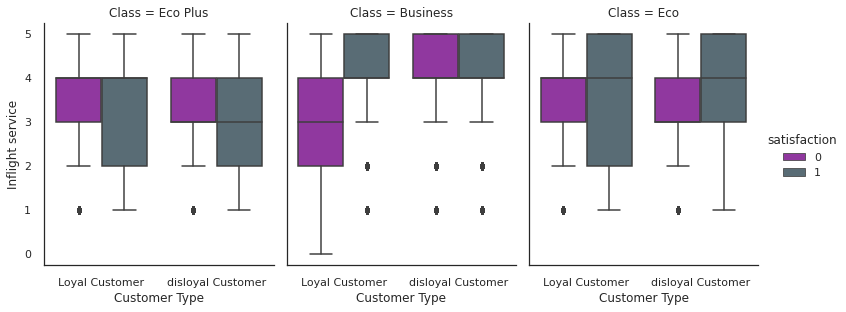

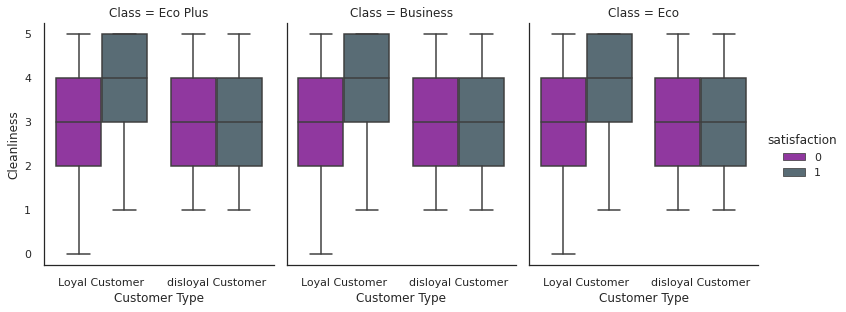

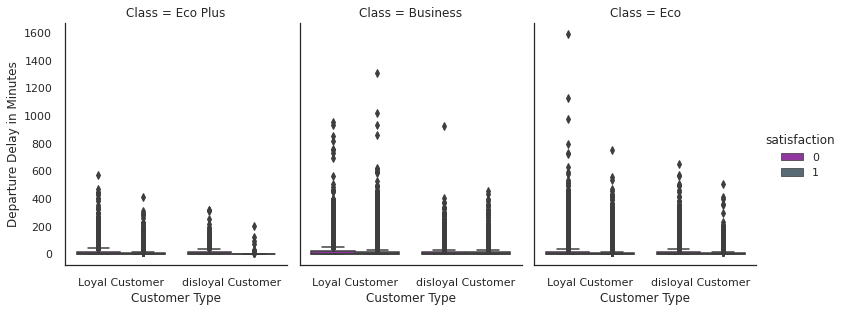

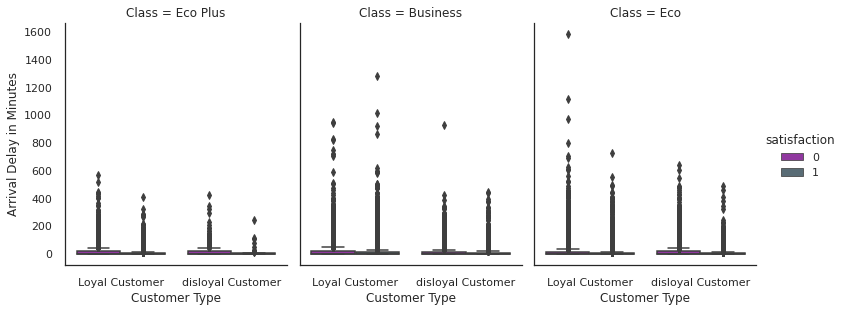

In [ ]:
pal = ["#9c27b0", "#546e7a","#00b8d4"]
temp=df.drop(columns=['Gender','Type of Travel'])
with sns.axes_style('white'):
      g = sns.catplot(x="Customer Type", y=temp.columns[1], hue="satisfaction", col="Class", data=temp, kind="box", height=4.5, aspect=.8,palette=pal)
      for i in range(3,20):
        g = sns.catplot(x="Customer Type", y=temp.columns[i], hue="satisfaction", col="Class", data=temp, kind="box", height=4.5, aspect=.8,palette=pal)


---
## EFA

In [ ]:
from sklearn.decomposition import FactorAnalysis #EFA
efa_data = train_d.iloc[:, :-1]
X = efa_data.copy() 
X = (X - X.mean()) / X.std()
X.head()

Age  Flight Distance  Inflight wifi service  \
id                                                         
70172  -1.745271        -0.731535               0.203578   
5047   -0.951356        -0.957179               0.203578   
110028 -0.885196        -0.047584              -0.549531   
24026  -0.951356        -0.629243              -0.549531   
119299  1.430390        -0.978239               0.203578   

        Departure/Arrival time convenient  Ease of Online booking  \
id                                                                  
70172                            0.616169                0.173775   
5047                            -0.695242                0.173775   
110028                          -0.695242               -0.541057   
24026                            1.271874                1.603440   
119299                          -0.039536                0.173775   

        Gate location  Food and drink  Online boarding  Seat comfort  \
id                                                                     
70172       -1.547315        1.352258        -0.185531      1.183094   
5047         0.018094       -1.656318        -0.185531     -1.849306   
110028      -0.764611        1.352258         1.296490      1.183094   
24026        1.583504       -0.904174        -0.926541     -1.091206   
119299       0.018094        0.600114         1.296490      1.183094   

        Inflight entertainment  ...  Checkin service  Inflight service  \
id                              ...                                      
70172                 1.231698  ...         0.549796          1.156430   
5047                 -1.769073  ...        -1.821004          0.305846   
110028                1.231698  ...         0.549796          0.305846   
24026                -1.018880  ...        -1.821004          0.305846   
119299               -0.268687  ...        -0.240471         -0.544737   

        Cleanliness  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                          
70172      1.305863                    0.266391                  0.074169   
5047      -1.742283                   -0.361373                 -0.236312   
110028     1.305863                   -0.387530                 -0.391552   
24026     -0.980246                   -0.099805                 -0.158692   
119299    -0.218210                   -0.387530                 -0.391552   

        Gender_Male  Customer Type_disloyal Customer  \
id                                                     
70172      1.015026                        -0.472764   
5047       1.015026                         2.115198   
110028    -0.985187                        -0.472764   
24026     -0.985187                        -0.472764   
119299     1.015026                        -0.472764   

        Type of Travel_Personal Travel  Class_Eco  Class_Eco Plus  
id                                                                 
70172                         1.490607  -0.904322        3.586758  
5047                         -0.670861  -0.904322       -0.278801  
110028                       -0.670861  -0.904322       -0.278801  
24026                        -0.670861  -0.904322       -0.278801  
119299                       -0.670861  -0.904322       -0.278801  

[5 rows x 23 columns]

In [ ]:
efa = FactorAnalysis(n_components=3) #numbers of latent factors
efa.fit(X) #Estimating the EFA model with the fit method

#1. ecpected values (use transform function)
ev_scores = pd.DataFrame(
    efa.transform(X),
    columns=['ev_F1', 'ev_F2','ev_F3'],  # prefix labels with ev_ as well
)
#ev_scores
#ev_scores.iloc[4,1] #5th obsevation, 2nd factor 

In [ ]:
#2. loading matrix: 𝚪
loadings = pd.DataFrame(
    efa.components_.T,  # don't forget to transpose with .T
    index=X.columns,
    columns=['F1', 'F2','F3'],
).round(3)
loadings #equals to the cov, any combo of large numbers/ratio

F1     F2     F3
Age                               -0.099  0.009  0.081
Flight Distance                   -0.179  0.015 -0.020
Inflight wifi service             -0.499 -0.613  0.007
Departure/Arrival time convenient -0.198 -0.425 -0.032
Ease of Online booking            -0.415 -0.830  0.040
Gate location                     -0.177 -0.451  0.037
Food and drink                    -0.610  0.291  0.357
Online boarding                   -0.522 -0.217  0.132
Seat comfort                      -0.653  0.297  0.320
Inflight entertainment            -0.819  0.352 -0.039
On-board service                  -0.412  0.127 -0.554
Leg room service                  -0.328  0.018 -0.376
Baggage handling                  -0.385  0.112 -0.652
Checkin service                   -0.227  0.080 -0.169
Inflight service                  -0.397  0.125 -0.694
Cleanliness                       -0.705  0.350  0.343
Departure Delay in Minutes         0.039 -0.010  0.026
Arrival Delay in Minutes           0.043 -0.010  0.029
Gender_Male                       -0.011 -0.002 -0.044
Customer Type_disloyal Customer    0.123 -0.024 -0.069
Type of Travel_Personal Travel     0.188  0.046 -0.010
Class_Eco                          0.253 -0.015  0.077
Class_Eco Plus                     0.061 -0.015  0.047

In [ ]:
loadings.iloc[:,0].sort_values()

Inflight entertainment              -0.819
Cleanliness                         -0.705
Seat comfort                        -0.653
Food and drink                      -0.610
Online boarding                     -0.522
Inflight wifi service               -0.499
Ease of Online booking              -0.415
On-board service                    -0.412
Inflight service                    -0.397
Baggage handling                    -0.385
Leg room service                    -0.328
Checkin service                     -0.227
Departure/Arrival time convenient   -0.198
Flight Distance                     -0.179
Gate location                       -0.177
Age                                 -0.099
Gender_Male                         -0.011
Departure Delay in Minutes           0.039
Arrival Delay in Minutes             0.043
Class_Eco Plus                       0.061
Customer Type_disloyal Customer      0.123
Type of Travel_Personal Travel       0.188
Class_Eco                            0.253
Name: F1, d

In [ ]:
loadings.iloc[:,1].sort_values()

Ease of Online booking              -0.830
Inflight wifi service               -0.613
Gate location                       -0.451
Departure/Arrival time convenient   -0.425
Online boarding                     -0.217
Customer Type_disloyal Customer     -0.024
Class_Eco Plus                      -0.015
Class_Eco                           -0.015
Arrival Delay in Minutes            -0.010
Departure Delay in Minutes          -0.010
Gender_Male                         -0.002
Age                                  0.009
Flight Distance                      0.015
Leg room service                     0.018
Type of Travel_Personal Travel       0.046
Checkin service                      0.080
Baggage handling                     0.112
Inflight service                     0.125
On-board service                     0.127
Food and drink                       0.291
Seat comfort                         0.297
Cleanliness                          0.350
Inflight entertainment               0.352
Name: F2, d

In [ ]:
loadings.iloc[:,2].sort_values()

Inflight service                    -0.694
Baggage handling                    -0.652
On-board service                    -0.554
Leg room service                    -0.376
Checkin service                     -0.169
Customer Type_disloyal Customer     -0.069
Gender_Male                         -0.044
Inflight entertainment              -0.039
Departure/Arrival time convenient   -0.032
Flight Distance                     -0.020
Type of Travel_Personal Travel      -0.010
Inflight wifi service                0.007
Departure Delay in Minutes           0.026
Arrival Delay in Minutes             0.029
Gate location                        0.037
Ease of Online booking               0.040
Class_Eco Plus                       0.047
Class_Eco                            0.077
Age                                  0.081
Online boarding                      0.132
Seat comfort                         0.320
Cleanliness                          0.343
Food and drink                       0.357
Name: F3, d

F1: 
1. Inflight entertainment              -0.819
2. Cleanliness                         -0.705
3. Seat comfort                        -0.653
4. Food and drink                      -0.610

F2: 
1. Ease of Online booking              -0.830

F3:
1. Inflight service                    -0.694
2. Baggage handling                    -0.652

In [ ]:
#2.5 
explained_variance_per_factor = (loadings**2).sum(axis=0)
explained_variance_per_factor
#total_variance_explained = explained_variance_per_factor.sum()
#X.var(ddof=0).sum() #bigger than the above ones

F1    3.528765
F2    1.969752
F3    1.777491
dtype: float64

In [ ]:
#3. communalities ,
#___ of variance for variable () is explained by the latent factors 
#(least/most explained)
communalities = (loadings**2).sum(axis=1) #factoranalysis
communalities.sort_values()

Gender_Male                          0.002061
Departure Delay in Minutes           0.002297
Arrival Delay in Minutes             0.002790
Class_Eco Plus                       0.006155
Age                                  0.016443
Customer Type_disloyal Customer      0.020466
Flight Distance                      0.032666
Type of Travel_Personal Travel       0.037560
Class_Eco                            0.070163
Checkin service                      0.086490
Departure/Arrival time convenient    0.220853
Gate location                        0.236099
Leg room service                     0.249284
Online boarding                      0.336997
On-board service                     0.492789
Food and drink                       0.584230
Baggage handling                     0.585873
Seat comfort                         0.617018
Inflight wifi service                0.624819
Inflight service                     0.654870
Cleanliness                          0.737174
Inflight entertainment            

In [ ]:
#4. unique_variances (small var shared across, large only uniqe of their own)
unique_variances = pd.Series(
    efa.noise_variance_,
    index=X.columns,
)
unique_variances.sort_values()

Ease of Online booking               0.139537
Inflight entertainment               0.203863
Cleanliness                          0.263570
Inflight service                     0.347242
Inflight wifi service                0.374318
Seat comfort                         0.382794
Food and drink                       0.413601
Baggage handling                     0.415501
On-board service                     0.503774
Online boarding                      0.663075
Leg room service                     0.750044
Gate location                        0.763686
Departure/Arrival time convenient    0.778544
Checkin service                      0.914052
Class_Eco                            0.930196
Type of Travel_Personal Travel       0.962387
Flight Distance                      0.967142
Customer Type_disloyal Customer      0.979412
Age                                  0.983661
Class_Eco Plus                       0.993609
Arrival Delay in Minutes             0.997338
Departure Delay in Minutes        

### Rotations & Plot

In [ ]:
#5. Rotation (Varimax ROtation - orthogonal rotation)
# To maximize the variance across all the elements in the loadings matrix
loadings_as_vector = np.ravel(loadings)
np.var(loadings_as_vector)

# This cell is not part of this course
def compute_varimax_rotation_matrix(loadings, tol=1e-7, max_iter=1000):
    # Returns the rotation matrix for varimax based on the loadings matrix
    N, L = loadings.shape
    rotation_matrix = np.eye(L)
    var = 0

    for _ in range(max_iter):
        loadings_rot = loadings @ rotation_matrix
        tmp = loadings_rot * np.transpose((loadings_rot**2).sum(axis=0) / N)
        u, s, v = np.linalg.svd(loadings.T @ (loadings_rot**3 - tmp))
        rotation_matrix = u @ v
        var_new = np.sum(s)
        if var != 0 and var_new < var * (1 + tol):
            break
        var = var_new

    return rotation_matrix

# This IS part of the course
rotation_matrix = compute_varimax_rotation_matrix(loadings)

rotated_loadings = loadings @ rotation_matrix
#values: first column(factor): large loading means strongly connected, small value means not connected
#neg/pos: large positive meaning positive response, large neg meaning negative response

rotated_ev_scores = ev_scores @ rotation_matrix
#ev_score: satisfied with '0' factor (large positive values of loadings), dissatified with '1' factor 

rotation_matrix


array([[ 0.80056537,  0.44681368,  0.39931519],
       [-0.42552639,  0.89306195, -0.14617677],
       [-0.42192699, -0.05289509,  0.90508548]])

In [ ]:
rotated_loadings.round(3)


0      1      2
Age                               -0.117 -0.040  0.032
Flight Distance                   -0.141 -0.066 -0.092
Inflight wifi service             -0.142 -0.771 -0.103
Departure/Arrival time convenient  0.036 -0.466 -0.046
Ease of Online booking             0.004 -0.929 -0.008
Gate location                      0.035 -0.484  0.029
Food and drink                    -0.763 -0.032  0.037
Online boarding                   -0.381 -0.434 -0.057
Seat comfort                      -0.784 -0.043 -0.015
Inflight entertainment            -0.789 -0.050 -0.414
On-board service                  -0.150 -0.041 -0.684
Leg room service                  -0.112 -0.111 -0.474
Baggage handling                  -0.081 -0.038 -0.760
Checkin service                   -0.144 -0.021 -0.255
Inflight service                  -0.078 -0.029 -0.805
Cleanliness                       -0.858 -0.021 -0.022
Departure Delay in Minutes         0.025  0.007  0.041
Arrival Delay in Minutes           0.026  0.009  0.045
Gender_Male                        0.011 -0.004 -0.044
Customer Type_disloyal Customer    0.138  0.037 -0.010
Type of Travel_Personal Travel     0.135  0.126  0.059
Class_Eco                          0.176  0.096  0.173
Class_Eco Plus                     0.035  0.011  0.069

In [ ]:
rotated_ev_scores


0         1         2
0      -1.231276  0.021881 -0.533096
1       1.932060 -0.223859  0.216533
2      -1.460231  0.567413 -0.231298
3       1.247236 -1.205037  0.212525
4      -0.323785 -0.272447  0.316500
...          ...       ...       ...
103899  1.117629  0.604743  0.315079
103900 -0.525996 -0.909908 -1.414880
103901 -0.619619  1.377699 -0.435329
103902  1.911333  1.129131  0.098640
103903  1.923707  0.153744  0.496414

[103904 rows x 3 columns]

In [ ]:

unique_variances = pd.Series(
    efa.noise_variance_,
    index=X.columns,
)
unique_variances


Age                                  0.983661
Flight Distance                      0.967142
Inflight wifi service                0.374318
Departure/Arrival time convenient    0.778544
Ease of Online booking               0.139537
Gate location                        0.763686
Food and drink                       0.413601
Online boarding                      0.663075
Seat comfort                         0.382794
Inflight entertainment               0.203863
On-board service                     0.503774
Leg room service                     0.750044
Baggage handling                     0.415501
Checkin service                      0.914052
Inflight service                     0.347242
Cleanliness                          0.263570
Departure Delay in Minutes           0.997782
Arrival Delay in Minutes             0.997338
Gender_Male                          0.998163
Customer Type_disloyal Customer      0.979412
Type of Travel_Personal Travel       0.962387
Class_Eco                         

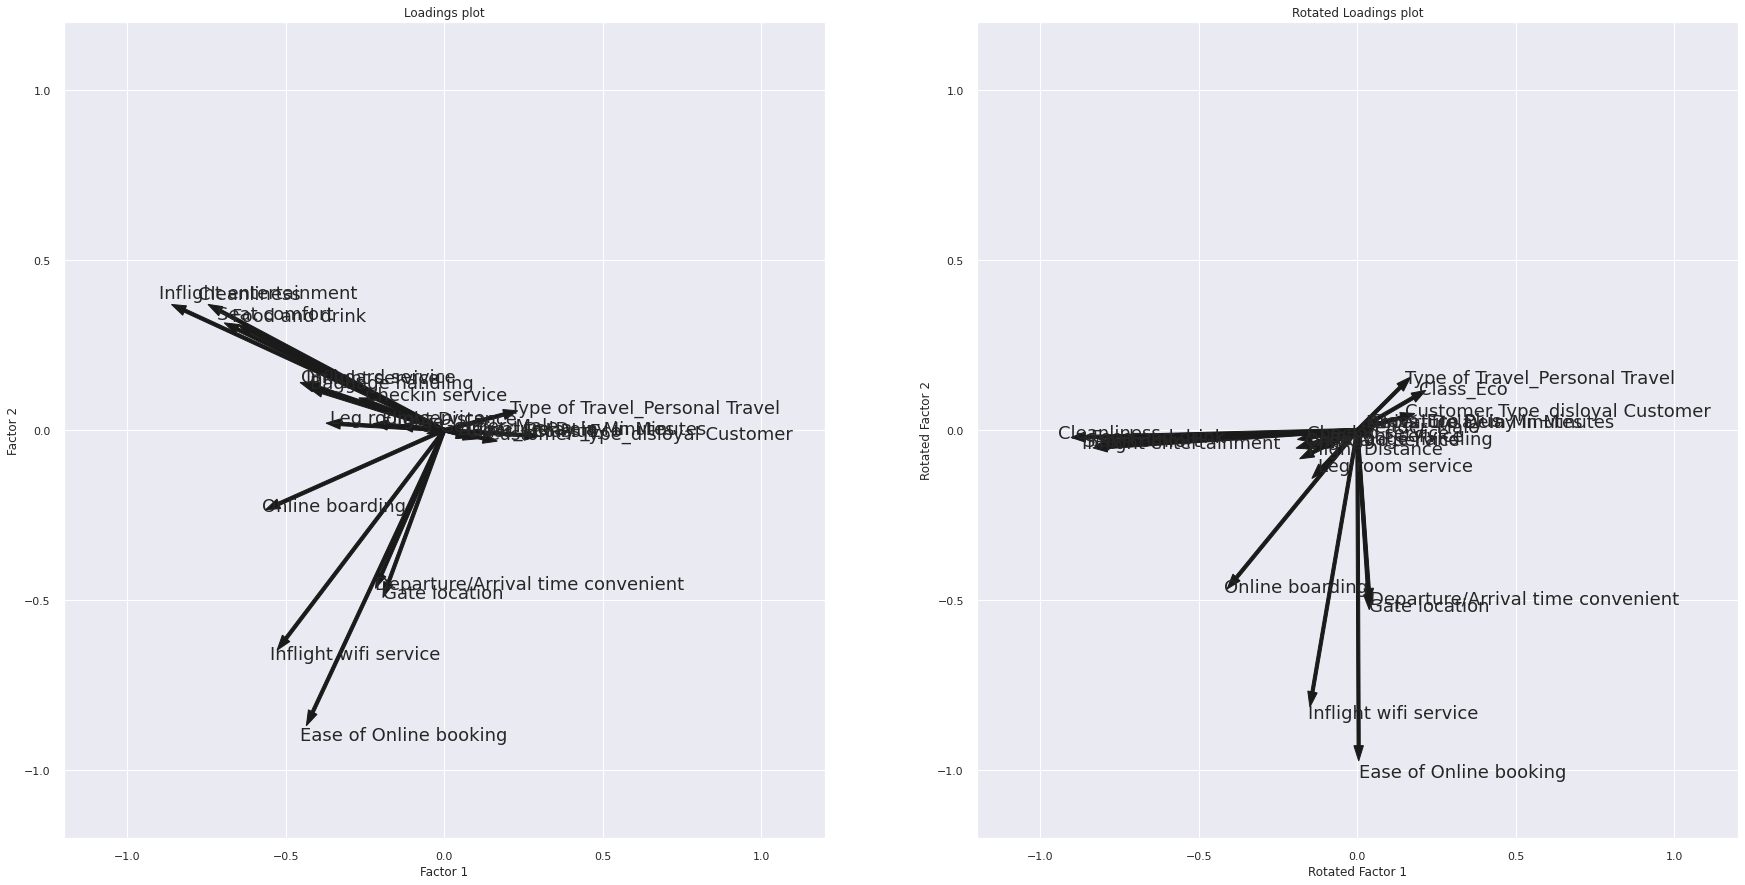

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=[30, 15])

# Loadings plot
ax[0].set_title('Loadings plot')
ax[0].set_xlabel('Factor 1')
ax[0].set_ylabel('Factor 2')

xlim_val = np.max((1.2, np.max(np.abs(loadings.loc[:, 'F1']))))
ax[0].set_xlim([-xlim_val, xlim_val])

ylim_val = np.max((1.2, np.max(np.abs(loadings.loc[:, 'F2']))))
ax[0].set_ylim([-ylim_val, ylim_val])

for variable in loadings.index.values:
    ax[0].arrow(
        x=0,
        y=0,
        dx=loadings.loc[variable]['F1'],
        dy=loadings.loc[variable]['F2'],
        width=0.01,
        color='k'
    )

    ax[0].text(
        x=1.1*loadings.loc[variable]['F1'],
        y=1.1*loadings.loc[variable]['F2'],
        s=variable,
        fontsize=18,
    )

# Rotated loadings plot
ax[1].set_title('Rotated Loadings plot')
ax[1].set_xlabel('Rotated Factor 1')
ax[1].set_ylabel('Rotated Factor 2')

xlim_val = np.max((1.2, np.max(np.abs(rotated_loadings.loc[:, 0]))))
ax[1].set_xlim([-xlim_val, xlim_val])

ylim_val = np.max((1.2, np.max(np.abs(rotated_loadings.loc[:, 1]))))
ax[1].set_ylim([-ylim_val, ylim_val])

for variable in rotated_loadings.index.values:
    ax[1].arrow(
        x=0,
        y=0,
        dx=rotated_loadings.loc[variable][0],
        dy=rotated_loadings.loc[variable][1],
        width=0.01,
        color='k'
    )

    ax[1].text(
        x=1.1*rotated_loadings.loc[variable][0],
        y=1.1*rotated_loadings.loc[variable][1],
        s=variable,
        fontsize=18,
    )

plt.show()

##PCA

In [ ]:
from sklearn.decomposition import PCA
#Try PCA
#initiate function; data refer to data source after processing; X equals to N X P original matrix
X = X_train_os
X
# always demean the original matrix to help interpretation in the original X matrix
X = X - X.mean()
# standardized the data (optional !!!)
X = X / X.std()
# go PCA
pca_corr = PCA().fit(X)

In [ ]:
# direction matrix
pca_corr_directions = pd.DataFrame(
pca_corr.components_.T,
index=X.columns,
columns=['PC' + str(l + 1) for l in range(pca_corr.n_components_)],
)
# score matrix
pca_corr_scores = pd.DataFrame(
pca_corr.transform(X), # Should be the same as for the fit method!
columns=['PC' + str(l + 1) for l in range(pca_corr.n_components_)],
)
#check if the matrix is right
assert np.allclose(X, pca_corr_scores @ pca_corr_directions.T)

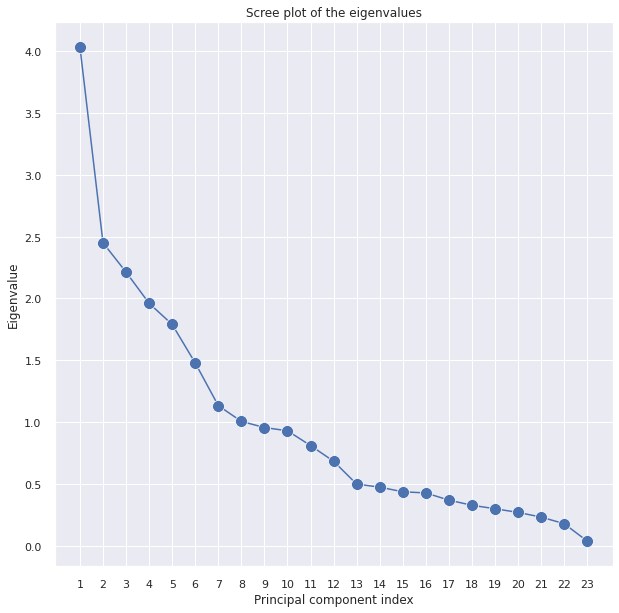

array([0.17532246, 0.28182539, 0.37801871, 0.4632426 , 0.54104986,
       0.60531129, 0.65458323, 0.69833416, 0.73990844, 0.78035393,
       0.81560732, 0.84534265, 0.86704205, 0.88768092, 0.90668327,
       0.92528265, 0.94134619, 0.95561975, 0.9686547 , 0.98041581,
       0.99052875, 0.99832465, 1.        ])

In [ ]:
# extract eigenvalue for each principal component
pca_corr_eigenvalues=pca_corr.explained_variance_
#Scree plot
plt.figure(figsize=(10, 10))
plt.title('Scree plot of the eigenvalues')
plt.xlabel('Principal component index')
plt.ylabel('Eigenvalue')
sns.lineplot(
x=np.arange(len(pca_corr_eigenvalues)) + 1,
y=pca_corr_eigenvalues,
marker='o',
markersize=12,
)
plt.xticks(np.arange(len(pca_corr_eigenvalues)) + 1)
plt.show()

#cumulative explained variance ratio
np.cumsum(pca_corr.explained_variance_ratio_)


In [ ]:
# Elementwise: Divide each column by the sqrt of its corresponding eigenva
#lue
# a lot of machine learning method requires standardized input and it 
#helps interpretation in the result
pca_corr_scores_standardized = pca_corr_scores / np.sqrt(pca_corr_eigenvalues)
# Elementwise: Multiply each column by the sqrt of its corresponding eigen
#value
pca_corr_loadings = pca_corr_directions * np.sqrt(pca_corr_eigenvalues)
pca_corr_loadings.round(2)
#check the matrix if is right
assert np.allclose(X, pca_corr_scores_standardized @ pca_corr_loadings.T)


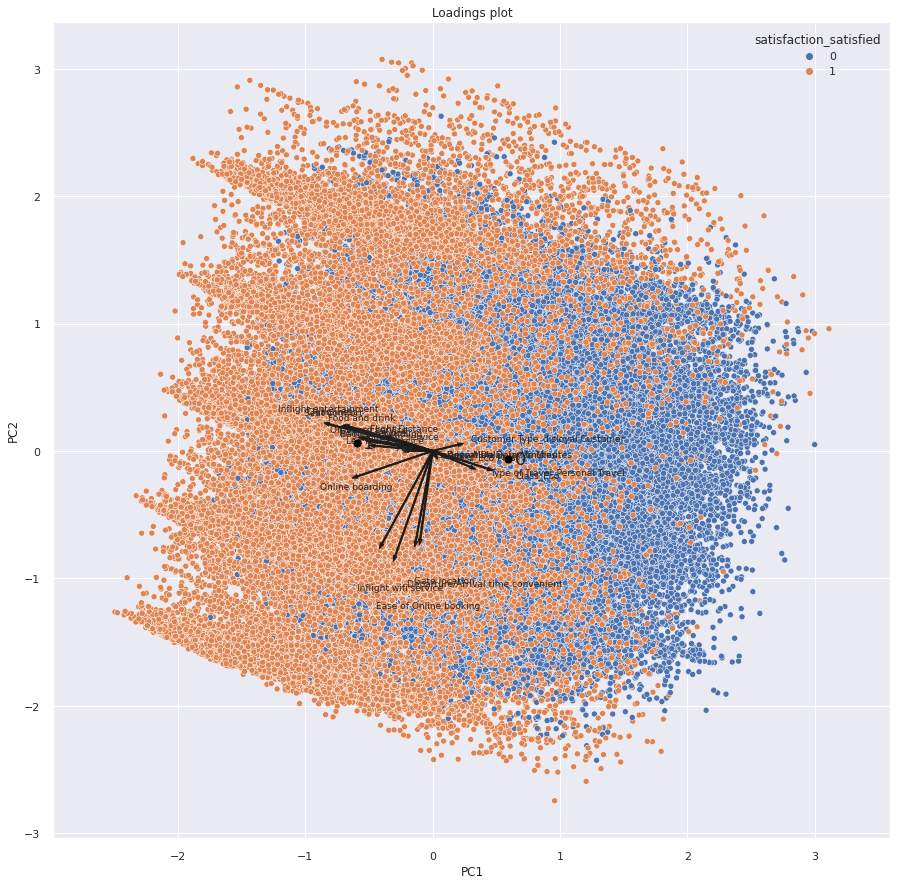

In [ ]:
#biplot
fig = plt.figure(figsize=[15, 15])
plt.title('Loadings plot')
plt.xlabel('PC1')
plt.ylabel('PC2')
xlim_val = np.max((1.1, np.max(np.abs(pca_corr_loadings.loc[:, 'PC1']))))
plt.xlim([-xlim_val, xlim_val])
ylim_val = np.max((1.1, np.max(np.abs(pca_corr_loadings.loc[:, 'PC2']))))
plt.ylim([-ylim_val, ylim_val])
for variable in pca_corr_loadings.index.values:
  plt.arrow(
    x=0,
    y=0,
    dx=pca_corr_loadings.loc[variable]['PC1'],
    dy=pca_corr_loadings.loc[variable]['PC2'],
    width=0.01,
    color='k'
    )
  plt.text(
  x=1.5*pca_corr_loadings.loc[variable]['PC1'],
  y=1.5*pca_corr_loadings.loc[variable]['PC2'],
  s=variable,
  fontsize=9,
  )
g = sns.scatterplot(
x=pca_corr_scores_standardized.iloc[:, 0],
y=pca_corr_scores_standardized.iloc[:, 1],
hue=y_train_os,
)
for brand_label in y_train_os.unique():
  brand_pca_mean_scores = pca_corr_scores_standardized.loc[y_train_os == brand_label].mean()
  plt.scatter(
  brand_pca_mean_scores.values[0],
  brand_pca_mean_scores.values[1],
  s=50,
  c='black',
  zorder=10
  )
  plt.text(
  x=brand_pca_mean_scores.values[0] + 0.05,
  y=brand_pca_mean_scores.values[1] - 0.04,
  s=brand_label,
  fontsize=18,
  )
g.axis('equal')
plt.show()

In [ ]:
# This cell is not part of this course
def compute_varimax_rotation_matrix(loadings, tol=1e-7, max_iter=1000):
# Returns the rotation matrix for varimax based on the loadings matrix
  N, L = loadings.shape
  rotation_matrix = np.eye(L)
  var = 0
  for _ in range(max_iter):
    loadings_rot = loadings @ rotation_matrix
    tmp = loadings_rot * np.transpose((loadings_rot**2).sum(axis=0)/N)
    u, s, v = np.linalg.svd(loadings.T @ (loadings_rot**3 - tmp))
    rotation_matrix = u @ v
    var_new = np.sum(s)
    if var != 0 and var_new < var * (1 + tol):
      break
    var = var_new
  return rotation_matrix
# This cell IS part of the course
rotation_matrix = compute_varimax_rotation_matrix(pca_corr_loadings)
rotation_matrix
#Rotating loadings
rotated_loadings = pca_corr_loadings @ rotation_matrix
rotated_loadings.round(3)


0      1      2      3      4      5   \
Age                               -0.012  0.002  0.020 -0.006 -0.026 -0.132   
Flight Distance                   -0.027  0.015 -0.019  0.001 -0.111 -0.113   
Inflight wifi service             -0.040 -0.943 -0.038 -0.009 -0.041  0.010   
Departure/Arrival time convenient  0.001 -0.198 -0.026  0.000  0.133 -0.098   
Ease of Online booking             0.022 -0.565 -0.000 -0.001 -0.061  0.010   
Gate location                      0.001 -0.191  0.003  0.005 -0.014  0.015   
Food and drink                    -0.280 -0.047  0.003 -0.013 -0.015 -0.017   
Online boarding                   -0.127 -0.259 -0.017 -0.013 -0.101 -0.097   
Seat comfort                      -0.325 -0.019 -0.012 -0.018 -0.049 -0.075   
Inflight entertainment            -0.419 -0.090 -0.193 -0.019 -0.085 -0.073   
On-board service                  -0.040 -0.038 -0.221 -0.024 -0.017 -0.024   
Leg room service                  -0.031 -0.064 -0.143  0.010 -0.054 -0.027   
Baggage handling                  -0.033 -0.038 -0.905  0.000 -0.001  0.022   
Checkin service                   -0.059  0.000 -0.081 -0.010  0.019 -0.002   
Inflight service                  -0.029 -0.031 -0.296 -0.041  0.003  0.021   
Cleanliness                       -0.877 -0.033 -0.022 -0.004 -0.022 -0.028   
Departure Delay in Minutes         0.003  0.004  0.000  0.990 -0.000  0.002   
Arrival Delay in Minutes           0.003  0.005  0.002  0.990 -0.002  0.002   
Gender_Male                       -0.002 -0.003 -0.011  0.003  0.014 -0.006   
Customer Type_disloyal Customer    0.030 -0.010 -0.018  0.003 -0.149  0.958   
Type of Travel_Personal Travel     0.028  0.057  0.000 -0.003  0.916 -0.174   
Class_Eco                          0.037 -0.003  0.055  0.010  0.286  0.081   
Class_Eco Plus                     0.011 -0.007  0.022  0.006  0.057 -0.024   

                                      6      7      8      9   ...     13  \
Age                               -0.008  0.004 -0.011 -0.000  ...  0.026   
Flight Distance                   -0.069 -0.005 -0.026 -0.002  ...  0.036   
Inflight wifi service              0.011  0.002 -0.001 -0.158  ...  0.039   
Departure/Arrival time convenient  0.019  0.009 -0.048 -0.239  ...  0.025   
Ease of Online booking            -0.013  0.007  0.009 -0.262  ... -0.001   
Gate location                      0.001  0.007  0.019 -0.950  ... -0.018   
Food and drink                    -0.003  0.005 -0.025  0.003  ...  0.003   
Online boarding                   -0.046 -0.031 -0.098  0.039  ...  0.049   
Seat comfort                      -0.029 -0.020 -0.087 -0.005  ...  0.037   
Inflight entertainment            -0.015 -0.009  0.005 -0.001  ...  0.234   
On-board service                  -0.033 -0.004 -0.100  0.020  ...  0.917   
Leg room service                  -0.027  0.009 -0.057  0.009  ...  0.140   
Baggage handling                  -0.026  0.014 -0.098  0.003  ...  0.229   
Checkin service                   -0.028  0.003 -0.979  0.017  ...  0.084   
Inflight service                  -0.025  0.014 -0.102  0.001  ...  0.253   
Cleanliness                       -0.012  0.005 -0.079  0.002  ...  0.029   
Departure Delay in Minutes         0.002  0.003  0.005 -0.002  ... -0.010   
Arrival Delay in Minutes           0.004  0.000  0.006 -0.002  ... -0.012   
Gender_Male                        0.002  0.999 -0.003 -0.006  ... -0.003   
Customer Type_disloyal Customer   -0.026 -0.007  0.001 -0.013  ... -0.021   
Type of Travel_Personal Travel     0.075  0.018 -0.024  0.016  ... -0.016   
Class_Eco                         -0.158  0.018  0.059 -0.006  ... -0.073   
Class_Eco Plus                     0.987  0.003  0.028 -0.001  ... -0.028   

                                      14     15     16     17     18     19  \
Age                               -0.013 -0.002 -0.022 -0.076  0.055  0.046   
Flight Distance                    0.008  0.015  0.015 -0.070  0.045  0.162   
Inflight wifi service             -0.151  0.053  0.031 

## MDS

In [ ]:
from sklearn.manifold import MDS
#function to compute the ‘loading matrix’
def compute_corr_X_Z(df_X, df_Z):
  K_X = df_X.shape[1]
  corr_X_Z = pd.concat([df_X, df_Z], axis=1).corr().iloc[:K_X, K_X:]
  return pd.DataFrame(
      corr_X_Z.values,
      index=df_X.columns,
      columns=df_Z.columns,
)

X = X_train_os
# We apply MDS to standardized data (!!!)
X = X - X.mean()
X = X / X.std()
# go MDS
mds=MDS(random_state=42,n_init=4,max_iter=300,n_components=2,dissimilarity='euclidean')
mds
mds.fit(X.iloc[0:2000])

MDS(random_state=42)

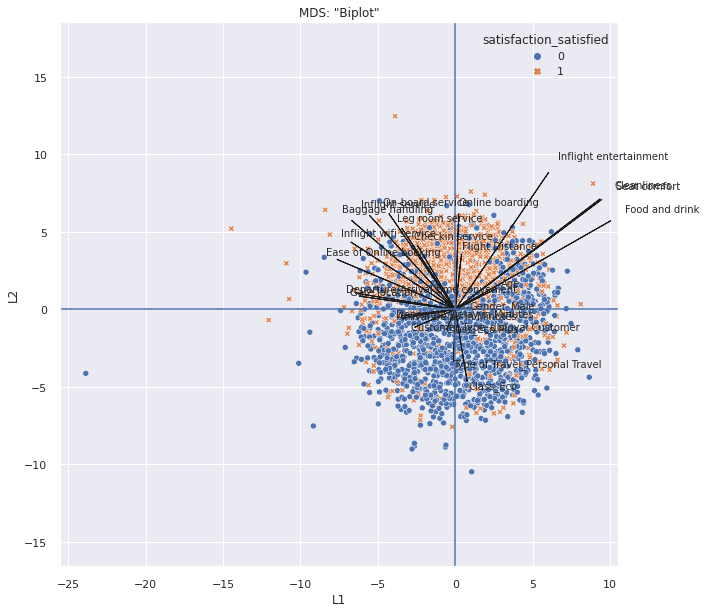

In [ ]:
# score matrix
C = mds.embedding_
C = pd.DataFrame(
    C,
    columns=['L1', 'L2'], # named the two dimensions L1 (horizontal) and L2 (vertical)
)
# loading matrix
X_C_corr = compute_corr_X_Z(X, C)
X_C_corr

#biplot
y_group = pd.Series(y_train_os) 

# for group_idx, group_name in enumerate(y_train_os):
#     y_group[y_group == group_idx] = group_name

# y_group
fig, ax = plt.subplots(figsize=[10, 10])

# create line for the axes
plt.axhline(0)
plt.axvline(0)

# create a scatterplot of the MDS coordinates
sns.scatterplot(
    x='L1',
    y='L2',
    data=C,
    # THE 2 LINES BELOW ARE NOW ADDED
    style=y_group,
    hue=y_group,
)
plt.axis('equal')

abs_xlim = 0.9 * np.max(np.abs(C.iloc[:, 0]))
abs_ylim = 0.9 * np.max(np.abs(C.iloc[:, 1]))

for variable in X_C_corr.index.values:
    ax.arrow(
        x=0,
        y=0,
        dx=X_C_corr.loc[variable]['L1'] * abs_xlim,
        dy=X_C_corr.loc[variable]['L2'] * abs_ylim,
        width=0.01,
        color='k'
    )

    ax.text(
        x=1.1*X_C_corr.loc[variable]['L1'] * abs_xlim,
        y=1.1*X_C_corr.loc[variable]['L2'] * abs_ylim,
        s=variable,
        fontsize=10,
    )

plt.title('MDS: "Biplot"')
plt.show()



In [ ]:
X_C_corr
# This cell is not part of this course
def compute_varimax_rotation_matrix(loadings, tol=1e-7, max_iter=1000):
# Returns the rotation matrix for varimax based on the loadings matrix
  N, L = loadings.shape
  rotation_matrix = np.eye(L)
  var = 0
  for _ in range(max_iter):
    loadings_rot = loadings @ rotation_matrix
    tmp = loadings_rot * np.transpose((loadings_rot**2).sum(axis=0)/N)
    u, s, v = np.linalg.svd(loadings.T @ (loadings_rot**3 - tmp))
    rotation_matrix = u @ v
    var_new = np.sum(s)
    if var != 0 and var_new < var * (1 + tol):
      break
    var = var_new
  return rotation_matrix
# This cell IS part of the course
rotation_matrix_mds = compute_varimax_rotation_matrix(X_C_corr)
rotation_matrix_mds
#Rotating loadings
rotated_loadings = X_C_corr @ rotation_matrix_mds
rotated_loadings.round(3)

0      1
Age                                0.023  0.172
Flight Distance                   -0.181  0.259
Inflight wifi service             -0.484  0.109
Departure/Arrival time convenient -0.291 -0.112
Ease of Online booking            -0.455  0.005
Gate location                     -0.272 -0.119
Food and drink                     0.050  0.687
Online boarding                   -0.331  0.435
Seat comfort                      -0.046  0.767
Inflight entertainment            -0.267  0.790
On-board service                  -0.495  0.307
Leg room service                  -0.413  0.265
Baggage handling                  -0.560  0.207
Checkin service                   -0.316  0.217
Inflight service                  -0.535  0.263
Cleanliness                       -0.052  0.765
Departure Delay in Minutes        -0.104 -0.129
Arrival Delay in Minutes          -0.093 -0.137
Gender_Male                        0.025  0.029
Customer Type_disloyal Customer   -0.032 -0.154
Type of Travel_Personal Travel     0.181 -0.237
Class_Eco                          0.282 -0.300
Class_Eco Plus                     0.050 -0.104

In [ ]:
X = X_train_os
# We apply MDS to standardized data (!!!)
X = X - X.mean()
X = X / X.std()
# go MDS
mds=MDS(random_state=42,n_init=4,max_iter=300,n_components=2,dissimilarity='euclidean')
mds
X_T=X.iloc[0:2000].T
mds.fit(X_T)

MDS(random_state=42)

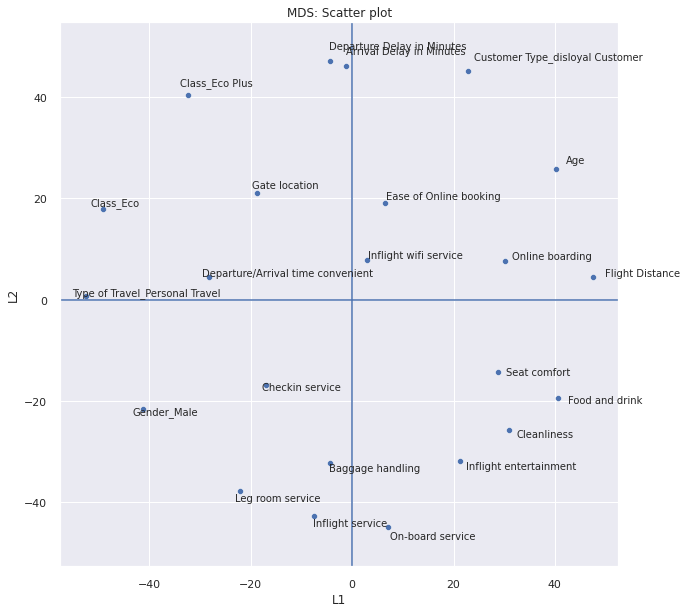

In [ ]:
# score matrix
C = mds.embedding_
C = pd.DataFrame(
    C,
    columns=['L1', 'L2'], # named the two dimensions L1 (horizontal) and L2 (vertical)
)
# Note: Execute this cell _after_ you have created C

plt.figure(figsize=(10, 10))

# create line for the axes
plt.axhline(0)
plt.axvline(0)

# create a scatterplot of the MDS coordinates
sns.scatterplot(
    x='L1',
    y='L2',
    data=C,
)
plt.axis('equal')

for i in range(X_T.shape[0]):

    # this plots the label for each variable
    plt.annotate(
        s=X_T.index[i],
        xy=[
            C.iloc[i, 0] * 1.05,
            C.iloc[i, 1] * 1.05,
        ],
        fontsize=10
    )  
    
plt.title('MDS: Scatter plot')
plt.show()

##Hierarchical clustering

N: 23 P: 88404


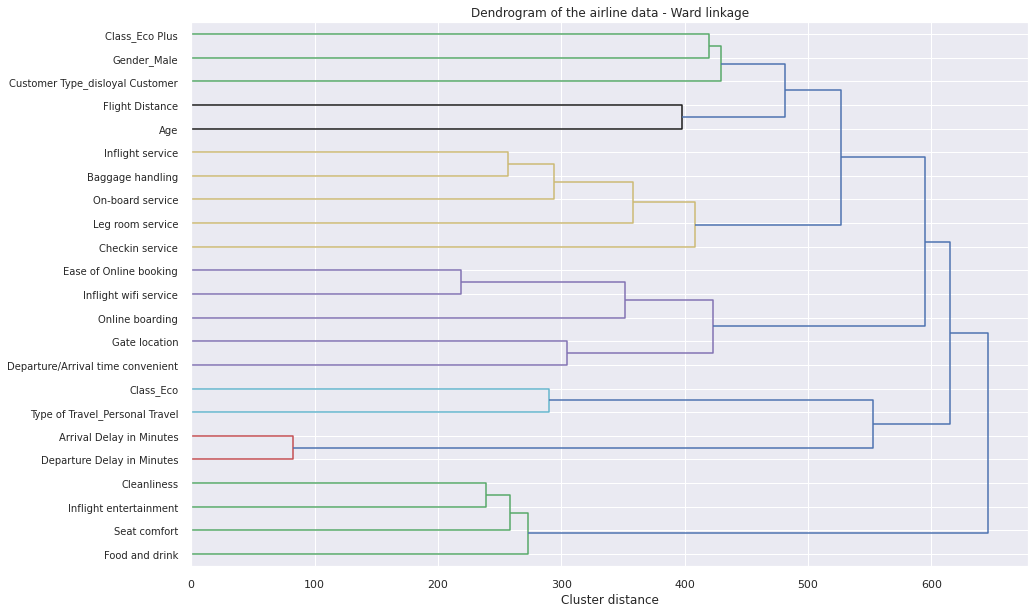

In [ ]:
X = X_train_os
#standardlized data
X = (X - X.mean()) / X.std()
#
X=X.T
# get N and P
N, P = X.shape
print('N:', N, 'P:', P)
# go Hierarchical clustering
numpy_Z = linkage(X, method='ward')

Z = pd.DataFrame(
    numpy_Z,
    columns=['cluster_A', 'cluster_B', 'distance', 'size_new_cluster']
)

# convert the integer values to integers in the dataframe
Z['cluster_A'] = Z['cluster_A'].astype(int)
Z['cluster_B'] = Z['cluster_B'].astype(int)
Z['size_new_cluster'] = Z['size_new_cluster'].astype(int)

Z.head()

#cluster number equal to index in original dataset before N-1
X.iloc[[14, 15]]

#add cluster number after beginning to merge
Z['cluster_number'] = N + np.arange(N - 1)
Z.head()

# initialize a new figure
fig = plt.figure(figsize=(15, 10))

# create the dendrogram
dn = dendrogram(
    linkage(X, method='ward'), # change method if necessary
    orientation='right',
    labels=X.index,
)

# Add title and x-axis label
plt.title('Dendrogram of the airline data - Ward linkage') # don't forget to change your title!
plt.xlabel('Cluster distance')

# show the figure
plt.show()



---
# Predictive Modeling (Classifier)

In [ ]:
#packages
from sklearn.metrics import roc_auc_score, r2_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import f1_score, balanced_accuracy_score, plot_roc_curve
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import PredictionError, ResidualsPlot

---
##Logistic Regression

In [ ]:
X_test.isnull().sum()

Age                                  0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
Gender_Male                          0
Customer Type_disloyal Customer      0
Type of Travel_Personal Travel       0
Class_Eco                            0
Class_Eco Plus                       0
dtype: int64

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)



 Validation clasification report:
               precision    recall  f1-score   support

           0       0.85      0.81      0.83     14677
           1       0.77      0.81      0.79     11299

    accuracy                           0.81     25976
   macro avg       0.81      0.81      0.81     25976
weighted avg       0.81      0.81      0.81     25976


 Validation confussion matrix:
 [[11869  2808]
 [ 2110  9189]]

 Accuracy: 
 0.8106713889744379

 Validation ROC AUC: 
 0.8109690292163937


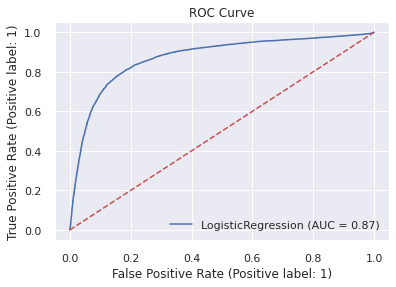

In [ ]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(random_state = 42)
log.fit(X_train, y_train)


# Calculate evaluation metrics for classification model
train_y_pred = log.predict(X_train) # Predictions for training data
train_y_true = y_train # True values for training data

val_y_pred = log.predict(X_val) # Predictions for val data
val_y_true = y_val # True values for val data

print('\n Validation clasification report:\n', classification_report(val_y_true, val_y_pred))
print('\n Validation confussion matrix:\n',confusion_matrix(val_y_true, val_y_pred))
print('\n Accuracy: \n',accuracy_score(val_y_true, val_y_pred))
print('\n Validation ROC AUC: \n',roc_auc_score(val_y_true, val_y_pred))

# ROC CURVE
plot_roc_curve(log, X_val, y_val)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()


 Testing clasification report:
               precision    recall  f1-score   support

           0       0.85      0.82      0.83     14573
           1       0.78      0.82      0.80     11403

    accuracy                           0.82     25976
   macro avg       0.81      0.82      0.81     25976
weighted avg       0.82      0.82      0.82     25976


 Testing confussion matrix:
 [[11882  2691]
 [ 2092  9311]]

 Accuracy: 
 0.8158684939944564

 Testing ROC AUC: 
 0.815941475250695


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


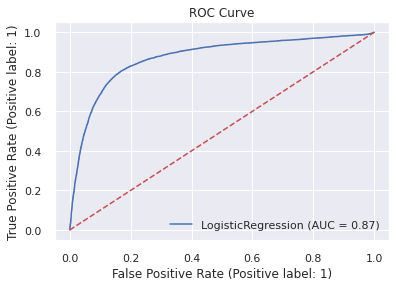

In [ ]:
#testing data
test_y_pred = log.predict(X_test) # Predictions for testing data
test_y_true = y_test # True values for testing data

print('\n Testing clasification report:\n', classification_report(test_y_true, test_y_pred))
print('\n Testing confussion matrix:\n',confusion_matrix(test_y_true, test_y_pred))
print('\n Accuracy: \n',accuracy_score(test_y_true, test_y_pred))
print('\n Testing ROC AUC: \n',roc_auc_score(test_y_true, test_y_pred))

# ROC CURVE
plot_roc_curve(log, X_test, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

---
##K-NN

KNeighborsClassifier()
[0]Logistic Regression Training Accuracy: 0.827507442767683

 Validation clasification report:
               precision    recall  f1-score   support

           0       0.76      0.80      0.78     14677
           1       0.72      0.67      0.69     11299

    accuracy                           0.74     25976
   macro avg       0.74      0.73      0.74     25976
weighted avg       0.74      0.74      0.74     25976


 Validation confussion matrix:
 [[11803  2874]
 [ 3778  7521]]

 Validation ROC AUC: 
 0.7349087715716806


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


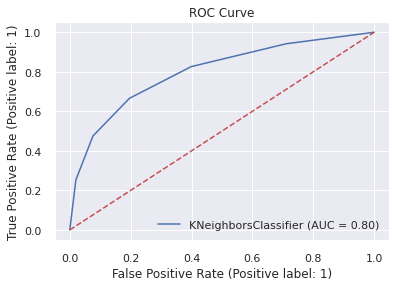

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
knn.fit(X_train, y_train)


# Calculate evaluation metrics for classification model
train_y_pred = knn.predict(X_train) # Predictions for training data
train_y_true = y_train # True values for training data

val_y_pred = knn.predict(X_val) # Predictions for val data
val_y_true = y_val # True values for val data

print(knn.fit(X_train, y_train))
print('[0]Logistic Regression Training Accuracy:', knn.score(X_train, y_train))

print('\n Validation clasification report:\n', classification_report(val_y_true, val_y_pred))
print('\n Validation confussion matrix:\n',confusion_matrix(val_y_true, val_y_pred))
print('\n Validation ROC AUC: \n',roc_auc_score(val_y_true, val_y_pred))

# ROC CURVE
plot_roc_curve(knn, X_val, y_val)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()


 Testing clasification report:
               precision    recall  f1-score   support

           0       0.75      0.80      0.77     14573
           1       0.72      0.66      0.69     11403

    accuracy                           0.74     25976
   macro avg       0.74      0.73      0.73     25976
weighted avg       0.74      0.74      0.74     25976


 Testing confussion matrix:
 [[11664  2909]
 [ 3888  7515]]

 Accuracy: 
 0.7383353865106252

 Testing ROC AUC: 
 0.7297106838927727


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


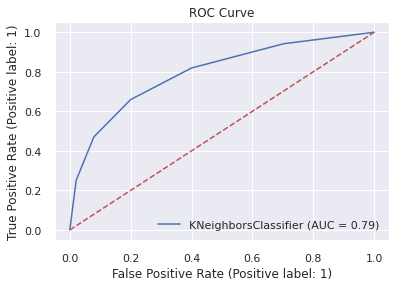

In [ ]:
#testing data
test_y_pred = knn.predict(X_test) # Predictions for testing data
test_y_true = y_test # True values for testing data

print('\n Testing clasification report:\n', classification_report(test_y_true, test_y_pred))
print('\n Testing confussion matrix:\n',confusion_matrix(test_y_true, test_y_pred))
print('\n Accuracy: \n',accuracy_score(test_y_true, test_y_pred))
print('\n Testing ROC AUC: \n',roc_auc_score(test_y_true, test_y_pred))

# ROC CURVE
plot_roc_curve(knn, X_test, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

## Decision Tree

Use all X variables

In [ ]:
#Using DecisionTreeClassifier of tree class to use Decision Tree Algorithm
from sklearn.tree import DecisionTreeClassifier
clf =DecisionTreeClassifier(random_state = 42)

params = {'criterion':['gini','entropy'],
         'max_depth': [2,4,6,8,10,12,14],
         'min_samples_split': [2,3,4],
         'min_samples_leaf': [1,2,3]}

gcv_dt1 = GridSearchCV(estimator=clf,param_grid=params)
gcv_dt1.fit(X_train_os, y_train_os)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4]})

DecisionTreeClassifier(criterion='entropy', max_depth=14, min_samples_leaf=2,
                       random_state=42)
[0]Decision Tree Training Accuracy: 0.9625808786932718
              precision    recall  f1-score   support

           0       0.95      0.96      0.95     14677
           1       0.94      0.94      0.94     11299

    accuracy                           0.95     25976
   macro avg       0.95      0.95      0.95     25976
weighted avg       0.95      0.95      0.95     25976

Accuracy: 0.9481444410224823
Precision: 0.9424684332207007
Recall: 0.9380476148331711
F1 Score: 0.9402528276779775
Roc Auc Score: 0.9469825183248092
Balanced Accuracy Score: 0.9469825183248093
Confusion Matrix: [[14030   647]
 [  700 10599]]



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


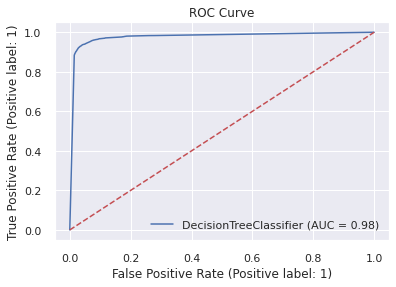

In [ ]:
##with out x variable selection
dt = gcv_dt1.best_estimator_
#dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 42)
dt.fit(X_train_os, y_train_os)

print(dt.fit(X_train_os, y_train_os))
print('[0]Decision Tree Training Accuracy:', dt.score(X_train_os, y_train_os))
#Check Accuracy precision, recall, f1-score
print( classification_report(y_val, dt.predict(X_val)) )
#Another way to get the models accuracy on the test data
print(F'Accuracy:',accuracy_score(y_val, dt.predict(X_val)))
print(F'Precision:', precision_score(y_val, dt.predict(X_val)))
print(F'Recall:', recall_score(y_val, dt.predict(X_val)))
print(F'F1 Score:', f1_score(y_val, dt.predict(X_val)))

#Check Roc Auc Score
print( F'Roc Auc Score:',roc_auc_score(y_val, dt.predict(X_val)) )
print( F'Balanced Accuracy Score:',balanced_accuracy_score(y_val, dt.predict(X_val)) ) 
print( F'Confusion Matrix:',confusion_matrix(y_val, dt.predict(X_val)) )
print()#Print a new line

# ROC CURVE
plot_roc_curve(dt, X_val, y_val)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

In [ ]:
#without X selection
from sklearn import metrics
from sklearn.metrics import r2_score

y_pred = dt.predict(X_test)
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Root Mean Squared Error: 0.2279715995473664


Use selected X variables

In [ ]:
#Using DecisionTreeClassifier of tree class to use Decision Tree Algorithm

X_train_selected = X_train_os[['Online boarding','Seat comfort','Inflight entertainment','On-board service','Leg room service','Cleanliness','Type of Travel_Personal Travel','Class_Eco']]

params = {'criterion':['gini','entropy'],
         'max_depth': [10,12,14,16,18,20],
         'min_samples_split': [2,3,4],
         'min_samples_leaf': [1,2,3]}

gcv_dt2 = GridSearchCV(estimator=clf,param_grid=params)
gcv_dt2.fit(X_train_selected, y_train_os)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 12, 14, 16, 18, 20],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4]})

DecisionTreeClassifier(max_depth=14, min_samples_leaf=3, random_state=42)
[0]Decision Tree Training Accuracy: 0.911395411972309
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     14677
           1       0.89      0.88      0.89     11299

    accuracy                           0.90     25976
   macro avg       0.90      0.90      0.90     25976
weighted avg       0.90      0.90      0.90     25976

Accuracy: 0.9007930397289806
Precision: 0.8868878637331441
Recall: 0.8847685635896982
F1 Score: 0.8858269460812547
Roc Auc Score: 0.8989489748520134
Balanced Accuracy Score: 0.8989489748520134
Confusion Matrix: [[13402  1275]
 [ 1302  9997]]



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


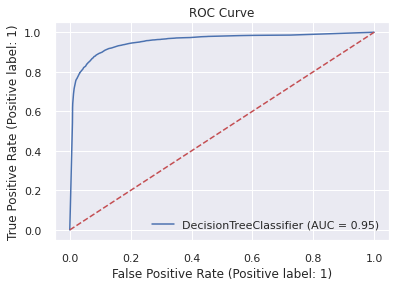

In [ ]:
dt = gcv_dt2.best_estimator_
#dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 42)
dt.fit(X_train_selected, y_train_os)

X_val_selected = X_val[['Online boarding','Seat comfort','Inflight entertainment','On-board service','Leg room service','Cleanliness','Type of Travel_Personal Travel','Class_Eco']]
#X_test_selected = X_test[['Online boarding','Seat comfort','Inflight entertainment','On-board service','Leg room service','Cleanliness','Type of Travel_Personal Travel','Class_Eco']]

print(dt.fit(X_train_selected, y_train_os))
print('[0]Decision Tree Training Accuracy:', dt.score(X_train_selected, y_train_os))
#Check Accuracy precision, recall, f1-score
print( classification_report(y_val, dt.predict(X_val_selected)) )
#Another way to get the models accuracy on the test data
print(F'Accuracy:',accuracy_score(y_val, dt.predict(X_val_selected)))
print(F'Precision:', precision_score(y_val, dt.predict(X_val_selected)))
print(F'Recall:', recall_score(y_val, dt.predict(X_val_selected)))
print(F'F1 Score:', f1_score(y_val, dt.predict(X_val_selected)))

#Check Roc Auc Score
print( F'Roc Auc Score:',roc_auc_score(y_val, dt.predict(X_val_selected)) )
print( F'Balanced Accuracy Score:',balanced_accuracy_score(y_val, dt.predict(X_val_selected)) ) 
print( F'Confusion Matrix:',confusion_matrix(y_val, dt.predict(X_val_selected)) )
print()#Print a new line

# ROC CURVE
plot_roc_curve(dt, X_val_selected, y_val)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

In [ ]:
#with X selection
X_test_selected = X_test[['Online boarding','Seat comfort','Inflight entertainment','On-board service','Leg room service','Cleanliness','Type of Travel_Personal Travel','Class_Eco']]

y_pred = dt.predict(X_test_selected)
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Root Mean Squared Error: 0.31637381841444095


In [ ]:
#Accuracy precision, recall, f1-score for Testing dataset, no X selection
print( classification_report(y_test, dt.predict(X_test)) )
#Another way to get the models accuracy on the test data
print(F'Accuracy:',accuracy_score(y_test, dt.predict(X_test)))
print(F'Precision:', precision_score(y_test, dt.predict(X_test)))
print(F'Recall:', recall_score(y_test, dt.predict(X_test)))
print(F'F1 Score:', f1_score(y_test, dt.predict(X_test)))

#Check Roc Auc Score
print( F'Roc Auc Score:',roc_auc_score(y_test, dt.predict(X_test)) )
print( F'Balanced Accuracy Score:',balanced_accuracy_score(y_test, dt.predict(X_test)) ) 
print( F'Confusion Matrix:',confusion_matrix(y_test, dt.predict(X_test)) )
print()#Print a new line

# ROC CURVE
plot_roc_curve(dt, X_test, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Age
- Arrival Delay in Minutes
- Baggage handling
- Checkin service
- Class_Eco Plus
- ...
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


ValueError: ignored

## Post pruning

In [ ]:
#post pruning
path = clf.cost_complexity_pruning_path(X_train_os, y_train_os)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)

In [ ]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train_os, y_train_os)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

In [ ]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

In [ ]:
train_scores = [clf.score(X_train_os, y_train_os) for clf in clfs]
#val_scores = [clf.score(X_val, y_val) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

### Graphing

In [ ]:
from sklearn.tree import export_graphviz
import graphviz 
export_graphviz(dt, out_file="mytree.dot")
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph) 

In [ ]:
from sklearn import tree
tree.plot_tree(dt)

## Random Forest

In [ ]:
#Using RandomForestClassifier method of ensemble class to use Random Forest Classification algorithm
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(random_state = 42)

#pruning
params = {'n_estimators':[10,50,100],
         'criterion':['gini','entropy'],
         'max_depth': [6,8,10,12],
         'min_samples_split': [2,3,4],
         'min_samples_leaf': [1,2,3]}

gcv_rf1 = GridSearchCV(estimator=forest,param_grid=params)
gcv_rf1.fit(X_train_os, y_train_os)

In [ ]:
#Without X selection

forest = gcv_rf1.best_estimator_
forest.fit(X_train_os, y_train_os)
print(forest.fit(X_train_os, y_train_os))
print('[0]Random Forest Training Accuracy:', forest.score(X_train_os, y_train_os))
#Check Accuracy precision, recall, f1-score
print( classification_report(y_val, forest.predict(X_val)) )
#Another way to get the models accuracy on the test data
print(F'Accuracy:',accuracy_score(y_val, forest.predict(X_val)))
print(F'Precision:', precision_score(y_val, forest.predict(X_val)))
print(F'Recall:', recall_score(y_val, forest.predict(X_val)))
print(F'F1 Score:', f1_score(y_val, forest.predict(X_val)))

#Check Roc Auc Score
print( F'Roc Auc Score:',roc_auc_score(y_val, forest.predict(X_val)) )
print( F'Balanced Accuracy Score:',balanced_accuracy_score(y_val, forest.predict(X_val)) ) 
print( F'Confusion Matrix:',confusion_matrix(y_val, forest.predict(X_val)) )
print()#Print a new line

# ROC CURVE
plot_roc_curve(forest, X_val, y_val)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

In [ ]:
#without X selection

y_pred = forest.predict(X_test)
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

with X selection

In [ ]:
#pruning
params = {'n_estimators':[10,50,100],
         'criterion':['gini','entropy'],
         'max_depth': [6,8,10,12],
         'min_samples_split': [2,3,4],
         'min_samples_leaf': [1,2,3]}

gcv_rf2 = GridSearchCV(estimator=forest,param_grid=params)
gcv_rf2.fit(X_train_selected, y_train_os)

In [ ]:
#With X selection
forest = gcv_rf2.best_estimator_
print(forest.fit(X_train_selected, y_train_os))
print('[0]Random Forest Training Accuracy:', forest.score(X_train_selected, y_train_os))
#Check Accuracy precision, recall, f1-score
print( classification_report(y_val, forest.predict(X_val_selected)) )
#Another way to get the models accuracy on the test data
print(F'Accuracy:',accuracy_score(y_val, forest.predict(X_val_selected)))
print(F'Precision:', precision_score(y_val, forest.predict(X_val_selected)))
print(F'Recall:', recall_score(y_val, forest.predict(X_val_selected)))
print(F'F1 Score:', f1_score(y_val, forest.predict(X_val_selected)))

#Check Roc Auc Score
print( F'Roc Auc Score:',roc_auc_score(y_val, forest.predict(X_val_selected)) )
print( F'Balanced Accuracy Score:',balanced_accuracy_score(y_val, forest.predict(X_val_selected)) ) 
print( F'Confusion Matrix:',confusion_matrix(y_val, forest.predict(X_val_selected)) )
print()#Print a new line

# ROC CURVE
plot_roc_curve(forest, X_val_selected, y_val)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

In [ ]:
#with X selection

y_pred = forest.predict(X_test_selected)
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
#Accuracy precision, recall, f1-score for Testing dataset, no X selection
print( classification_report(y_test, forest.predict(X_test)) )
#Another way to get the models accuracy on the test data
print(F'Accuracy:',accuracy_score(y_test, forest.predict(X_test)))
print(F'Precision:', precision_score(y_test, forest.predict(X_test)))
print(F'Recall:', recall_score(y_test, forest.predict(X_test)))
print(F'F1 Score:', f1_score(y_test, forest.predict(X_test)))

#Check Roc Auc Score
print( F'Roc Auc Score:',roc_auc_score(y_test, forest.predict(X_test)) )
print( F'Balanced Accuracy Score:',balanced_accuracy_score(y_test, forest.predict(X_test)) ) 
print( F'Confusion Matrix:',confusion_matrix(y_test, forest.predict(X_test)) )
print()#Print a new line

# ROC CURVE
plot_roc_curve(forest, X_test, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

##XGBoost with oversampling and without PCA

In [ ]:
import xgboost as xgb
#standaraized dataset
X_train_temp = X_train_os
X_train_temp = X_train_temp - X_train_temp.mean()
X_train_temp = X_train_temp / X_train_temp.std()
y_train_temp=y_train_os
#drop vif>3 variable
X_train_temp=X_train_temp.drop(columns=['Arrival Delay in Minutes','Inflight entertainment'])

#correlation matrix,shown only half; to detect multicollinearity
plt.figure(figsize=(15, 15))
matrix_corr = X_train_temp.corr().round(2)
mask = np.triu(np.ones_like(matrix_corr, dtype=bool))
sns.heatmap(matrix_corr, annot=True, vmax=1, 
            vmin=-1, center=0, cmap='vlag', mask=mask)
plt.show()

#Detect Multicollinearity using VIF
vif_data = pd.DataFrame()
vif_data["feature"] =X_train_temp.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train_temp.values, i)
						for i in range(len(X_train_temp.columns))]

print(vif_data)

#standaraized val dataset
X_val_temp=X_val
X_val_temp = X_val_temp - X_val_temp.mean()
X_val_temp = X_val_temp / X_val_temp.std()
X_val_temp=X_val_temp.drop(columns=['Arrival Delay in Minutes','Inflight entertainment'])
y_val_temp=y_val

In [ ]:
#Using xgboostr method of ensemble class to use xgboostClassification algorithm
x_gb= xgb.XGBClassifier(objective="binary:logistic", 
                        n_estimators=301, 
                        random_state=2020,
                        max_depth=18,
                        learning_rate=0.08080008698714111,
                        reg_alpha=80,
                        reg_lambda=60,
                        eval_metric=["auc", "error", "error@0.6"])
print(x_gb.fit(X_train_temp, y_train_temp))
print('XGBoost Training Accuracy:', x_gb.score(X_train_temp, y_train_temp))

#Check Accuracy precision, recall, f1-score
print( classification_report(y_val_temp, x_gb.predict(X_val_temp)) )

#Another way to get the models accuracy on the test data
# print(F'Accuracy:',accuracy_score(Y_test, x_gb.predict(X_test)))
# print(F'Precision:', precision_score(Y_test, x_gb.predict(X_test)))
# print(F'Recall:', recall_score(Y_test, x_gb.predict(X_test)))
# print(F'F1 Score:', f1_score(Y_test, x_gb.predict(X_test)))

#Check Roc Auc Score
print( F'Roc Auc Score:',roc_auc_score(y_val_temp, x_gb.predict(X_val_temp)) )
print( F'Balanced Accuracy Score:',balanced_accuracy_score(y_val_temp, x_gb.predict(X_val_temp)) ) 
print( F'Confusion Matrix:',confusion_matrix(y_val_temp, x_gb.predict(X_val_temp)) )
print()#Print a new line

# ROC CURVE
plot_roc_curve(x_gb, X_val_temp, y_val_temp)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

In [ ]:
# prepare to use optuna
def objective(trial,X_train=X_train_temp,y_train=y_train_temp,X_test=X_val_temp,y_test=y_val_temp):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 600),
        'max_depth': trial.suggest_int('max_depth', 1, 25),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 0.1),
        'reg_alpha': trial.suggest_int('reg_alpha', 30, 200),
        'reg_lambda': trial.suggest_int('reg_lambda', 30, 100),
        'objective' : "binary:logistic",
        'booster':'gbtree',
        'random_state': trial.suggest_categorical('random_state', [24, 42,2020]),

    }
    reg_model = xgb.XGBClassifier(**param)  
    
    reg_model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
    
    preds = reg_model.predict(X_test)
    
    accuracy = balanced_accuracy_score(y_test, preds)
    # we use auc score to evaluate classification model
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
study.trials_dataframe() 

#Visualize parameter importances.
fig=optuna.visualization.plot_param_importances(study)
fig.show()

#plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig1=optuna.visualization.plot_optimization_history(study)
fig1.show()


trial_best=study.best_trial
best_para=trial_best.params
print(best_para)

In [ ]:
#standaraized test dataset

X_test = X_test - X_test.mean()
X_test = X_test / X_test.std()
X_test=X_test.drop(columns=['Arrival Delay in Minutes','Inflight entertainment'])

In [ ]:
#Using xgboostr method of ensemble class to use xgboostClassification algorithm
x_gb= xgb.XGBClassifier(objective="binary:logistic", 
                        n_estimators=301, 
                        random_state=2020,
                        max_depth=18,
                        learning_rate=0.08080008698714111,
                        reg_alpha=80,
                        reg_lambda=60,
                        eval_metric=["auc", "error", "error@0.6"])
print(x_gb.fit(X_train_temp, y_train_temp))
print('XGBoost Training Accuracy:', x_gb.score(X_train_temp, y_train_temp))

#Check Accuracy precision, recall, f1-score
print( classification_report(y_test, x_gb.predict(X_test)) )


print(F'Accuracy:',accuracy_score(y_test, x_gb.predict(X_test)))
# print(F'Precision:', precision_score(Y_test, x_gb.predict(X_test)))
# print(F'Recall:', recall_score(Y_test, x_gb.predict(X_test)))
# print(F'F1 Score:', f1_score(Y_test, x_gb.predict(X_test)))

#Check Roc Auc Score
print( F'Roc Auc Score:',roc_auc_score(y_test, x_gb.predict(X_test)) )
print( F'Balanced Accuracy Score:',balanced_accuracy_score(y_test, x_gb.predict(X_test)) ) 
print( F'Confusion Matrix:',confusion_matrix(y_test, x_gb.predict(X_test)) )
print()#Print a new line

# ROC CURVE
plot_roc_curve(x_gb, X_test, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

In [ ]:
# prepare to use optuna
def objective(trial,X_train=X_train_temp,y_train=y_train_temp,X_test=X_test,y_test=y_test):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 600),
        'max_depth': trial.suggest_int('max_depth', 1, 25),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 0.1),
        'reg_alpha': trial.suggest_int('reg_alpha', 30, 200),
        'reg_lambda': trial.suggest_int('reg_lambda', 30, 100),
        'objective' : "binary:logistic",
        'booster':'gbtree',
        'random_state': trial.suggest_categorical('random_state', [24, 42,2020]),

    }
    reg_model = xgb.XGBClassifier(**param)  
    
    reg_model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
    
    preds = reg_model.predict(X_test)
    
    accuracy = balanced_accuracy_score(y_test, preds)
    # we use auc score to evaluate classification model
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
study.trials_dataframe() 

#Visualize parameter importances.
fig=optuna.visualization.plot_param_importances(study)
fig.show()

#plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig1=optuna.visualization.plot_optimization_history(study)
fig1.show()


trial_best=study.best_trial
best_para=trial_best.params
print(best_para)

##CATBOOST with oversampling and without PCA

In [ ]:
from catboost import CatBoostClassifier
#standaraized dataset
X_train_temp = X_train_os
X_train_temp = X_train_temp - X_train_temp.mean()
X_train_temp = X_train_temp / X_train_temp.std()
y_train_temp=y_train_os
#drop vif>3 variable
X_train_temp=X_train_temp.drop(columns=['Arrival Delay in Minutes','Inflight entertainment'])

#standaraized val dataset
X_val_temp=X_val
X_val_temp = X_val_temp - X_val_temp.mean()
X_val_temp = X_val_temp / X_val_temp.std()
X_val_temp=X_val_temp.drop(columns=['Arrival Delay in Minutes','Inflight entertainment'])
y_val_temp=y_val


In [ ]:

CatBoost = CatBoostClassifier(iterations=500,random_state=42,learning_rate=0.1)
print(CatBoost.fit(X_train_temp, y_train_temp))
print('CatBoost Training Accuracy:', CatBoost.score(X_train_temp, y_train_temp))

#Check Accuracy precision, recall, f1-score
print( classification_report(y_val_temp, CatBoost.predict(X_val_temp)) )
#Another way to get the models accuracy on the test data
print(F'Accuracy:',accuracy_score(y_val_temp, CatBoost.predict(X_val_temp)))
print(F'Precision:', precision_score(y_val_temp, CatBoost.predict(X_val_temp)))
print(F'Recall:', recall_score(y_val_temp, CatBoost.predict(X_val_temp)))
print(F'F1 Score:', f1_score(y_val_temp, CatBoost.predict(X_val_temp)))

#Check Roc Auc Score
print( F'Roc Auc Score:',roc_auc_score(y_val_temp, CatBoost.predict(X_val_temp)) )
print( F'Balanced Accuracy Score:',balanced_accuracy_score(y_val_temp, CatBoost.predict(X_val_temp)) ) 
print( F'Confusion Matrix:',confusion_matrix(y_val_temp, CatBoost.predict(X_val_temp)) )
print()#Print a new line

# ROC CURVE
plot_roc_curve(CatBoost, X_val_temp, y_val_temp)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

In [ ]:
def objective(trial,X_train=X_train_temp,y_train=y_train_temp,X_test=X_val_temp,y_test=y_val_temp):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 16),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.005, 0.05,0.1]),
        'iterations': 500,
        'random_state': trial.suggest_categorical('random_state', [42]),

    }
    
    model = CatBoostClassifier(**params)  
    model.fit(X_train, y_train, eval_set = [(X_test,y_test)], early_stopping_rounds = 222, verbose = False)
    y_pred = model.predict(X_test)
    accuracy = balanced_accuracy_score(y_test, y_pred)

    return accuracy
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
study.trials_dataframe() 

#Visualize parameter importances.
fig=optuna.visualization.plot_param_importances(study)
fig.show()

#plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig1=optuna.visualization.plot_optimization_history(study)
fig1.show()


trial_best=study.best_trial
best_para=trial_best.params
print(best_para)

In [ ]:
#CatBoost on Testing Dataset
CatBoost = CatBoostClassifier(iterations=500,random_state=42,learning_rate=0.1)
print(CatBoost.fit(X_train_temp, y_train_temp))
print('CatBoost Training Accuracy:', CatBoost.score(X_train_temp, y_train_temp))

#Check Accuracy precision, recall, f1-score
print( classification_report(y_test, CatBoost.predict(X_test)) )
#Another way to get the models accuracy on the test data
print(F'Accuracy:',accuracy_score(y_test, CatBoost.predict(X_test)))
print(F'Precision:', precision_score(y_test, CatBoost.predict(X_test)))
print(F'Recall:', recall_score(y_test, CatBoost.predict(X_test)))
print(F'F1 Score:', f1_score(y_test, CatBoost.predict(X_test)))

#Check Roc Auc Score
print( F'Roc Auc Score:',roc_auc_score(y_test, CatBoost.predict(X_test)) )
print( F'Balanced Accuracy Score:',balanced_accuracy_score(y_test, CatBoost.predict(X_test)) ) 
print( F'Confusion Matrix:',confusion_matrix(y_test, CatBoost.predict(X_test)) )
print()#Print a new line

# ROC CURVE
plot_roc_curve(CatBoost, X_test, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

In [ ]:
def objective(trial,X_train=X_train_temp,y_train=y_train_temp,X_test=X_test,y_test=y_test):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 16),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.005, 0.05,0.1]),
        'iterations': 500,
        'random_state': trial.suggest_categorical('random_state', [42]),

    }
    
    model = CatBoostClassifier(**params)  
    model.fit(X_train, y_train, eval_set = [(X_test,y_test)], early_stopping_rounds = 222, verbose = False)
    y_pred = model.predict(X_test)
    accuracy = balanced_accuracy_score(y_test, y_pred)

    return accuracy
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
study.trials_dataframe() 

#Visualize parameter importances.
fig=optuna.visualization.plot_param_importances(study)
fig.show()

#plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig1=optuna.visualization.plot_optimization_history(study)
fig1.show()


trial_best=study.best_trial
best_para=trial_best.params
print(best_para)

##ANN

In [ ]:
#standaraized dataset
X_train_temp = X_train_os
X_train_temp = X_train_temp - X_train_temp.mean()
X_train_temp = X_train_temp / X_train_temp.std()
y_train_temp=y_train_os
#drop vif>3 variable
X_train_temp=X_train_temp.drop(columns=['Arrival Delay in Minutes','Inflight entertainment'])

#standaraized val dataset
X_val_temp=X_val
X_val_temp = X_val_temp - X_val_temp.mean()
X_val_temp = X_val_temp / X_val_temp.std()
X_val_temp=X_val_temp.drop(columns=['Arrival Delay in Minutes','Inflight entertainment'])
y_val_temp=y_val


In [ ]:
#Initialising ANN
ann = tf.keras.models.Sequential()
#Adding First Hidden Layer
ann.add(tf.keras.layers.Dense(units=25,activation="relu"))
#Adding Second Hidden Layer
ann.add(tf.keras.layers.Dense(units=25,activation="relu"))
#Adding Output Layer
ann.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
#Compiling ANN
ann.compile(optimizer="adam",loss="binary_crossentropy",metrics=['accuracy'])
#Fitting ANN
ann.fit(X_train_temp,y_train_temp,batch_size=32,epochs = 100)
#prediction
y_pred = ann.predict(X_val_temp)
y_pred = (y_pred > 0.5)

#confusion matrix
cm = confusion_matrix(y_val_temp, y_pred)
print(cm)

#Saving created neural network
# ann.save("ANN.h5")

In [ ]:
#ANN on Testing Data
#Initialising ANN
ann = tf.keras.models.Sequential()
#Adding First Hidden Layer
ann.add(tf.keras.layers.Dense(units=25,activation="relu"))
#Adding Second Hidden Layer
ann.add(tf.keras.layers.Dense(units=25,activation="relu"))
#Adding Output Layer
ann.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
#Compiling ANN
ann.compile(optimizer="adam",loss="binary_crossentropy",metrics=['accuracy'])
#Fitting ANN
ann.fit(X_train_temp,y_train_temp,batch_size=32,epochs = 100)
#prediction
y_pred = ann.predict(X_test)
y_pred = (y_pred > 0.5)

#confusion matrix
cm = confusion_matrix(y_test, y_pred)


print(F'Accuracy:',accuracy_score(y_test, y_pred))
print( F'Roc Auc Score:',roc_auc_score(y_test, y_pred) )
print(cm)

## Naive Bayes

In [ ]:
#Implement Naive Bayes
from sklearn.naive_bayes import GaussianNB
gnb=GaussianNB()
gnb.fit(X_train, y_train)


In [ ]:
#Accuracy, precision, recall, F1 Score
from sklearn import metrics
print(F'Accuracy:',accuracy_score(y_test, gnb.predict(X_test)))
print(F'Precision:', precision_score(y_test, gnb.predict(X_test)))
print(F'Recall:', recall_score(y_test, gnb.predict(X_test)))
print(F'F1 Score:', f1_score(y_test, gnb.predict(X_test)))

In [ ]:
#Plot ROC Curve
plot_roc_curve(gnb, X_test, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()